# Section 4 - Computer vision-based machine learning #
## Mini-project 4: Building a 1D CNN for classification of waveforms ##

## Dr. Antonin Vacheret (avachere@imperial.ac.uk) 
## High Energy Physics Group
## 523 Blackett Lab

This projet is about designing a 1D Convolutional Neural Net (CNN) that classifies digitised signals from two type of scintillating materials used to record particle energy. 

There are many signal processing tasks where it is important to separate the signals recorded in different categories. Due the complex features of the signals recorded, a computer vision solution is well suited for solving this problem. 

We are dealing with two type of signals: 

* The first type of material is an organic scintillator (PVT) with a fast time response of a few nanoseconds. These fasts signals are also called Electron Scintillation (ES) signals.  

* The second type of material is an inorganic scintillator to detect neutrons (ZnS(Ag)), one of the oldest scintillator used. When a neutron is detected, the scintillation signal a long trail of fast pulses that slowly decreases in amplitude. These slow signals are called Nuclear Scintillation (NS) signals. 

We are interested here to separate as well as possible each type of signal and therefore coming up with a model that is able to have a very high score at predicting each class of signal.

Numpy files for the training and testing datasets (xtrain.npy, ytrain.npy) and their labels are already prepared. Each digitised waveform is a 1000 samples long with recorded pulses starting at a fixed time around 250 samples. Some examples of how to look at each signals and their label is provided below. Both type of signals have their amplitude normalised to the smallest pulse detectable i.e. what we call the 1 Photo-electron pulse. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# choose your preferred font size and style here for plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
# plt.rcParams['font.family'] = 'Times'
# plt.rcParams['font.serif'] = 'Times'

In [2]:
# importing the datasets
xtrain = np.load("x_train.npy")
ytrain = np.load("y_train.npy")
xtest = np.load("x_test.npy")
ytest = np.load("y_test.npy")
print(xtrain.shape,xtest.shape)
#print(ytrain)
#print(xtrain)


# Take integer value of either the first or the second column
# of ytrain/ytest. First column automatically determines the second's value
# Here, took first column
#ytrain_ = ytrain[:,0]
#ytest_ = ytest[:,0]

(12302, 1000) (3076, 1000)


Below we are displaying a few examples from the training set to get a feel for the variability of the signal waveforms. 

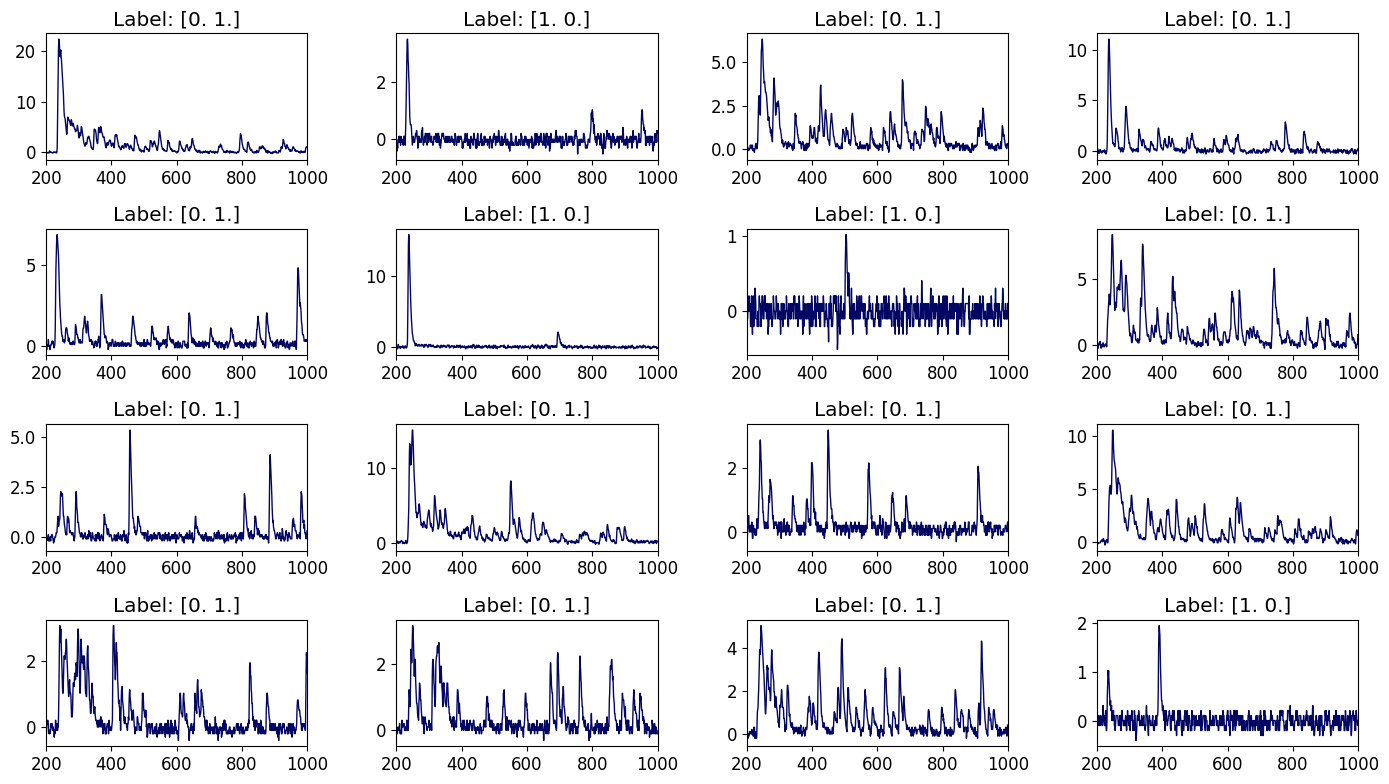

In [3]:
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.flatten()
for i in range(0, 16):
    j = np.random.randint(0, len(xtrain))
    #print(j)
    ax[i].plot(xtrain[j],color='xkcd:darkblue',lw=1)
    ax[i].set_title("Label: {}".format(ytrain[j]))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time
fig.tight_layout()

The fast ES signals have labels ```[1,0]``` and the slower signals NS from neutrons have the other value ```[0,1]```. Notice that you can have some 1 PE pulses being present in the waveform for ES signals but generally not with the same density as NS signals.   

### Building the 1-dimensional CNN to classify the waveforms

* The relatively large differences between these two type of signals means the classification with simple pulse processing method yields an Area Under the curve (Integral of the ROC curve) of better than 95%. It is therefore expected that a well designed CNN provides an AUC > 95% with the aim to reach better than 99%.
* It is expected that datasets and dataloaders are implemented. Example of visualisation of plots showing features of the waveforms with some discussion is also expected. 
* The steps in designing and optimising the architecture should be clearly presented with a schematic of the final model architecture. It is important to explain why you have chosen some specific parameters or functions and don't hesitate the cite the literature if you have find the information in an article. 
* training/testing Loss and Accuracy and other parameters of the training should also be shown along with the final results. 
* Provide a plot with the output of the model for each class as well as the final ROC curve and AUC. 
* Feel free to add feature maps and other visualisation to support your discussion of performance and why

# CID: 01876355

## Section 1: Data Exploration

After a brief search through the literature, we believe that we have found the exact paper on which this assignment is based, which is:
'Pulse Shape Discrimination and Exploration of Scintillation Signals Using Convolutional Neural Networks'. Though both [published](https://iopscience.iop.org/article/10.1088/2632-2153/abb781) and [pre-print](https://arxiv.org/abs/1807.06853) versions of this work exist, we will stick to the published version and will refer to this paper as 'ref.' throughout our analysis. We will attempt to beat the AUC-ROC score presented therein and replicate various figure and results as part of our analysis.

In [4]:
# Load in some necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from IPython.display import Image
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import time
from torchviz import make_dot

Let us first ensure that there are indeed only two types of waveforms in the training and testing sets. We can simply consider the unique labels in `ytrain` and `ytest`.

In [5]:
np.unique(ytrain, axis = 0)

array([[0., 1.],
       [1., 0.]])

In [6]:
np.unique(ytest, axis = 0)

array([[0., 1.],
       [1., 0.]])

Also, let us quickly check the number of training and testing samples:

In [7]:
print(f'Total training samples: {len(xtrain)}')
print(f'Total testing samples: {len(xtest)}')

Total training samples: 12302
Total testing samples: 3076


Since the data has already been split into training and testing sets, we can put aside the testing set and focus on performing a preliminary visual analysis of the training set to get a feel of the kind of data we are working with. We will try to replicate Figure-3 from ref.

In the given data, the class/label of each waveform is encoded as a one-hot vector. Specifically:

- An NS waveform is labeled as `[0, 1]`.
- An ES waveform is labeled as `[1, 0]`.

Since the labels represent only these two types of waveforms, we can simplify them by considering either the first or second entry in the one-hot vector. For instance:

- If the first entry is `0`, the waveform is NS.
- If the first entry is `1`, the waveform is ES.

For simplicity, we choose to use the first entry in the label vector. This approach allows us to represent the labels as:

- `0` for NS, or a waveform of type 0
- `1` for ES, or a waveform of type 1.

We will stick with this convention for the remainder of our analysis.

In [8]:
print('One-hot encoded vector labels')
print(ytrain)
labels = ytrain[:,0] # Choose first entry of one-hot label vectors
unique_labels = np.unique(labels)
print(f'Scalar labels: {labels}')
print(f'Unique scalar labels: {unique_labels}')

One-hot encoded vector labels
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]
Scalar labels: [1. 1. 1. ... 0. 1. 0.]
Unique scalar labels: [0. 1.]


Let us compute the average amplitude of each type of waveform, and also a measure of the spread of the signal distribution:

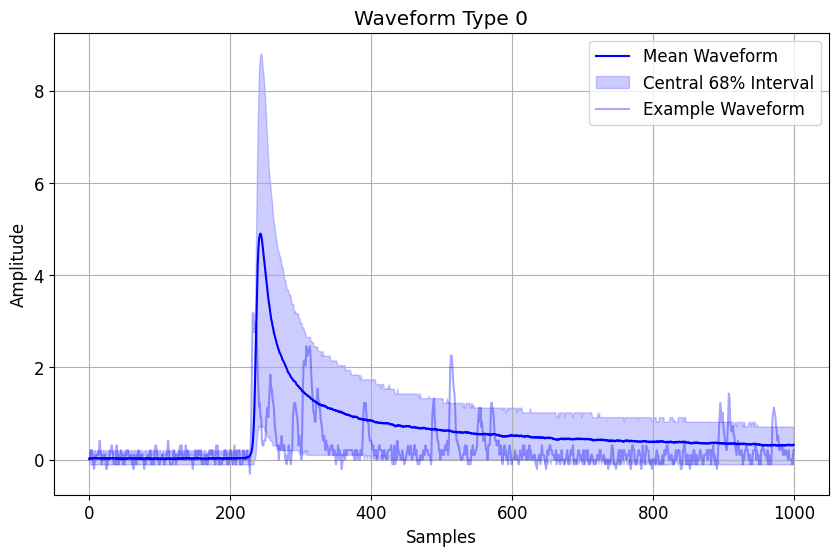

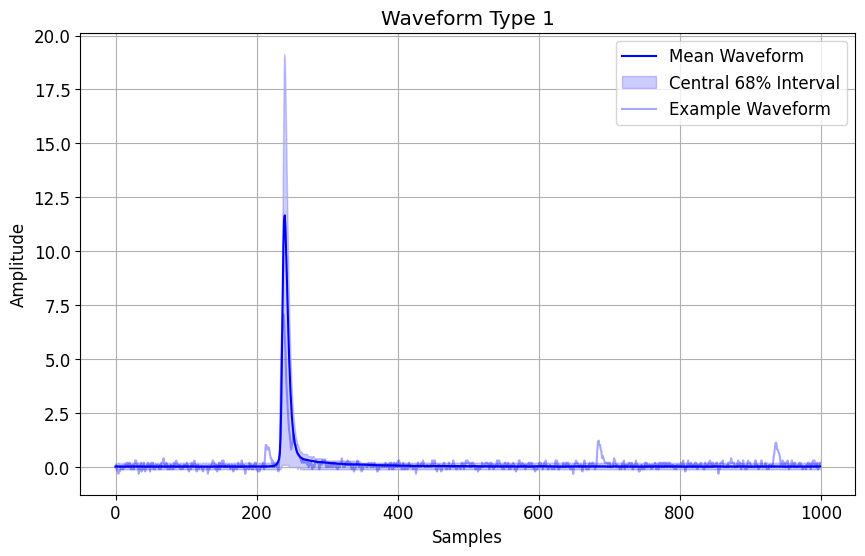

In [9]:
for unique_label in unique_labels:
    indices = np.where(labels == unique_label)
    waveforms  = xtrain[indices]
    mean_waveform = np.mean(waveforms, axis = 0)
    std_waveform = np.std(waveforms, axis = 0)
    lower_bound = np.percentile(waveforms, 16, axis=0)
    upper_bound = np.percentile(waveforms, 84, axis=0)
    example_waveform = waveforms[np.random.randint(0, len(waveforms))]
    plt.figure(figsize=(10, 6))
    plt.plot(mean_waveform, label='Mean Waveform', color='blue')
    plt.fill_between(range(len(mean_waveform)), 
                     lower_bound, 
                     upper_bound, 
                     color='blue', alpha=0.2, label='Central 68% Interval')
    plt.plot(example_waveform, label='Example Waveform', color='blue', alpha = 0.35)
    plt.title(f'Waveform Type {int(unique_label)}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

As in Figure 3 of ref., for each waveform type, the solid line is the averaged waveform and the shaded region is the central 68% of the signal distribution. The dashed line is an arbitrary example waveform of the given type.

We find that the Type 0 waveforms, on average, have a wider peak and larger spread about their mean than the Type 1 waveforms, which peak very sharply, and have a very tight spread around their mean.

## Section 2: Data Preparation

We can now proceed to prepare the data in a suitable fashion using PyTorch's `Dataset` and `DataLoader` primitives.

We will begin by constructing a class, `Waveforms1D`, which inherits from PyTorch's `Dataset` class. This class will be used in conjunction with PyTorch's `DataLoader` class to efficiently and correctly transform the data from its array format into the required tensor format for our neural network-based analysis.

Given this consideration, we construct the class as follows:

In [10]:
class Waveforms1D(Dataset):
    def __init__(self, X, y, transform = None):
        """
        Initialize the dataset with features and labels.

        Args:
            X (numpy.ndarray): Features, expected to be a 2D array (waveforms x samples).
            y (numpy.ndarray): Labels, expected to be a 1D array (waveform labels).
            transform (callable, optional): Optional transform to apply to the features.
        """
        
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()[:,0] # Using first entry of label vector as discriminator, as above
        self.transform = transform # for completeness

        # Need to ensure correct formatting of tensors for later use
        self.X = self.X.unsqueeze(1)
        self.y = self.y.unsqueeze(1)

    def __len__(self):
        """Return the number of samples in the dataset."""
        
        return len(self.X)
        
    def __getitem__(self, index):
        """
        Get a single sample from the dataset.

        Args:
            index (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing (features, target).
        """
        
        features = self.X[index]
        target = self.y[index]

        if self.transform:
            features = self.transform(features)

        return features, target

In [11]:
# Example usages, already know that y[2] and y[3] are different labels
print('Arrays:')
print(ytrain[2:4])
data = Waveforms1D(xtrain, ytrain)
f2, t2 = data[2]
f3, t3 = data[3]
print('\nTensors:')
print(t2)
print(t3)

Arrays:
[[1. 0.]
 [0. 1.]]

Tensors:
tensor([1.])
tensor([0.])


In the above example we use the `ytrain` array already loaded in as a reference, and check that we correctly return the appropriate class label for the third and fourth entries in `ytrain`, which happen to be ES and NS waveforms respectively.

We can expand our usage by incorporating the `DataLoader` class as follows:

In [12]:
data = Waveforms1D(xtrain, ytrain)
dataloader = DataLoader(data, batch_size = 64, shuffle = True)

for batch_features, batch_targets in dataloader:
    print(f'Batch features shape: {batch_features.shape}.\nBatch target shape: {batch_targets.shape}')
    break

Batch features shape: torch.Size([64, 1, 1000]).
Batch target shape: torch.Size([64, 1])


To remind ourselves, here we have 64 waveforms in each of our batches here, and each of the waveforms has 1000 samples/features and with 1 channel.

Let us prepare our data using the tools we have developed so far:

In [13]:
trainset = Waveforms1D(xtrain, ytrain)
testset = Waveforms1D(xtest, ytest)

batch_size = 10 # Can change

trainloader = DataLoader(trainset, batch_size = batch_size,
                         shuffle = True, num_workers = 2)

testloader = DataLoader(testset, batch_size = batch_size,
                         shuffle = False, num_workers = 2)

## Section 2: Constructing a 1D Convolution Neural Network

Next, we can proceed to develop a simple Convolutional Neural Network (CNN) model that we will train on this data. For now, we will focus on constructing the model, rather than finalizing specific details, such as the number of layers, activation functions, or other hyperparameters. However, we will aim to make the model's construction as generic and flexible as possible. This will allow us to dynamically construct CNNs of varying configurations and avoid hard-coding a single, fixed structure. By doing so, we can later experiment with a variety of architectures to determine the most effective one.

Given the nature of the problem and the provided data, it is clear that we will need to incorporate 1D convolutional layers and pooling layers within our models. This assumption is backed up by the ref. above. These layers are well-suited for capturing the temporal structure of waveforms. We will limit ourselves to these types of layers.

We will aim to capture the finer details of the temporal patterns present in the data. Since we are more interested in the capturing the temporal structure, and not the overall global structure of the waveforms, we should not have to use dilation for our layers.

A crucial consideration when constructing the model is how the shapes of tensors evolve as they pass through each layer of the network. To manage this, we should calculate the output shape of the tensor for each operation, given its input shape. PyTorch provides the relevant formulae for these calculations in its documentation ([here](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) and [here](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html)).

For the types of layers we will consider, the formula for the output shape/length ($L_{out}$) of the tensor, given its input shape/length ($L_{in}$), is as follows:

\begin{equation}
L_{out}=\Bigg\lfloor\frac{L_{in}+2\times\text{padding}−\text{dilation}\times(\text{kernel size}−1)−1}{\text{stride}}+1\Bigg\rfloor
\end{equation}
Here:

- padding: Padding added to both sides of the input
- dilation: Spacing between elements in the kernel (will not be using this much, but included for completeness)
- kernel size: Length of the convolution or pooling kernel
- stride: Step size for sliding the kernel across the input tensor
- ⌊⋅⌋: Floor operation (rounding down to the nearest integer)

This equation applies to both convolutional and pooling operations on 1D tensors and ensures we can accurately track how the tensor's shape changes after each layer.

Before constructing the model, let us define a function that dynamically calculates the output length of the tensor for each layer of our CNN. This function will be important for verifying that our model's architecture is valid and for debugging any mismatches in tensor shapes.

In [16]:
def L_out(L_in, kernel_size, stride=1, padding=0, dilation=1):
    """
    For a given layer with specified parameters, calculates the shape of the
    output tensor from the shape of the input to that layer.

    Parameters:
    L_in (int): The input length of the tensor.
    kernel_size (int): The size of the kernel (filter).
    stride (int): The stride of the convolution/pooling operation. Default is 1.
    padding (int): The padding applied to the input. Default is 0.
    dilation (int): The dilation factor of the kernel. Default is 1.

    Returns:
    int: The output length of the tensor.
    """
    if L_in <= 0 or kernel_size <= 0 or stride <= 0 or dilation <= 0:
        raise ValueError("L_in, kernel_size, stride, and dilation must be positive integers.")
    if kernel_size > L_in + 2 * padding:
        raise ValueError(f"Kernel size {kernel_size} is too large for input length {L_in} with padding {padding}.")
    
    return (L_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

We have added some additional checks to ensure that the parameters passed into this function are 'allowed'. Consider the following usage examples:

In [17]:
# Syntax: L_out(L_in, kernel_size, stride=1, padding=0, dilation=1)
L_in = 128

# Calculate output length
try:
    L_out_1 = L_out(L_in, 4, 2, 1, 1)
    print(f"Output length: {L_out_1}")
except ValueError as e:
    print(e)

Output length: 64


In [18]:
# Negative kernel length. Raises error.
try:
    L_out_2 = L_out(L_in, -4, 2, 1, 1)
    print(f"Output length: {L_out_1}")
except ValueError as e:
    print(e)

L_in, kernel_size, stride, and dilation must be positive integers.


In [19]:
# Kernel length too large. Raises error.
try:
    L_out_3 = L_out(L_in, 200, 2, 1, 1)
    print(f"Output length: {L_out_1}")
except ValueError as e:
    print(e)

Kernel size 200 is too large for input length 128 with padding 1.


We define another helper function that calculates the length of the output tensor from either a convolutional or pooling layer, depending on the type of layer. This will help in producing cleaner code later.

In [20]:
def layer_L_out(current_length, layer_config):
    """
    Compute the length of the output tensor for a specified layer configuration.

    Parameters:
    - current_length (int): The length of the input tensor.
    - layer_config (dict): A dictionary specifying layer parameters.
      - For 'conv': {'type': 'conv', 'kernel_size': int, 'stride': int (optional), 'padding': int (optional)}
      - For 'pool': {'type': 'pool', 'kernel_size': int, 'stride': int (optional), 'padding': int (optional)}

    Returns:
    - int: The length of the output tensor after applying the layer.

    Raises:
    - ValueError: If `layer_config['type']` is not 'conv' or 'pool', or if required parameters are missing.
    """
    # Validate layer type
    layer_type = layer_config.get('type')
    if layer_type not in {'conv', 'pool'}:
        raise ValueError(f"Invalid layer type: '{layer_type}'. Expected 'conv' or 'pool'.")

    # Extract parameters with defaults
    kernel_size = layer_config.get('kernel_size')
    # kernel_size needs specification
    if kernel_size is None:
        raise ValueError("Layer configuration must include 'kernel_size'.")

    # Others don't
    stride = layer_config.get('stride', 1 if layer_type == 'conv' else kernel_size) # In line with PyTorch doc, have different defaults
    padding = layer_config.get('padding', 0)

    # Calculate output length
    return L_out(current_length, kernel_size=kernel_size, stride=stride, padding=padding)

Consider an example:

In [21]:
# Convolutional layer
conv_config = {'type': 'conv', 'kernel_size': 3, 'stride': 1, 'padding': 1}
output_length_conv = layer_L_out(32, conv_config)  # Output: 32
print(f'Passed for configuration: {conv_config}')

# Pooling layer
pool_config = {'type': 'pool', 'kernel_size': 2, 'stride': 2}
output_length_pool = layer_L_out(32, pool_config)  # Output: 16
print(f'Passed for configuration: {pool_config}')

# Invalid layer type
try:
    invalid_config = {'type': 'invalid', 'kernel_size': 3}
    layer_L_out(32, invalid_config)
except ValueError as e:
    print(e)

Passed for configuration: {'type': 'conv', 'kernel_size': 3, 'stride': 1, 'padding': 1}
Passed for configuration: {'type': 'pool', 'kernel_size': 2, 'stride': 2}
Invalid layer type: 'invalid'. Expected 'conv' or 'pool'.


Now we write a class that dynamically constructs a 1D CNN with a user-specified configuration of convolutional, pooling, and fully connected layers to be used for binary classification. We also allow for the optional inclusions of BatchNormalization, for our convolution layers, and Dropout, in our fully-connected layers, to facilitate regularization and convergence during training. Additionally, we allow the implementation of user-specified activation functions for each of our layers.

It also includes methods to:

- Specify a loss function.
- Specify an optimizer with customizable parameters.
- Perform a complete forward pass of the CNN, along with optional plotting of the feature maps after each convolutional layer.
- Execute a complete training step: a forward pass, loss computation, backward pass, and optimizer step.
- Train the model for a complete epoch using a `DataLoader` object and the above methods.
- Track metrics such as loss, accuracy, AUC-score (calculate in an analogous fashion to accuracy), layer weights, and gradients. We will use a fixed learning rate so we will not have to track this.
- Fits the model to testing data to produce predictions and compute their accuracy.

In [22]:
class WF1D_CNN(nn.Module):
    def __init__(self, input_length, layers_config, fc_layers_config, 
                 activation_fn = nn.ReLU, dropout_prob = 0.5, batch_norm = False):
        """
        Dynamically build a 1D CNN with arbitrary configurations of convolutional, 
        pooling, and fully connected layers, with (optional) specification of 
        activation functions for each layer and (optional) inclusion of Dropout for fully-connected layers and 
        BatchNormalization for convolutional layers.

        Designed for binary classification, uses a sigmoid activation for the final
        output layer.
        
        Parameters:
        - input_length (int): Length of the input tensor.
        
        - layers_config (list of dicts): Each dict specifies the parameters for a Conv1D or MaxPool1D layer:
          - {'type': 'conv', 'in_channels': int, 'out_channels': int, 'kernel_size': int,
             'stride': int, 'padding': int, 'act_fc:' callable activation function}
             
          - {'type': 'pool', 'kernel_size': int, 'stride': int, 'padding': int}
          
        - fc_layers_config (list of dicts): Each dict specifies the parameters for a fully connected layer:
          - {'in_features': int, 'out_features': int, 'act_fn:' callable activation function}
          
        - activation_fn (nn.Module): Activation function to use. Default is nn.ReLU.
        
        - dropout_prob (float): Dropout probability for fully connected layers. Default is 0.5.
        
        - batch_norm (bool): Whether to include BatchNorm1d after convolutional layers. Default is False.
        """
        
        super(WF1D_CNN, self).__init__()

        # Validate configurations
        if not isinstance(layers_config, list) or not all(isinstance(cfg, dict) for cfg in layers_config):
            raise ValueError("layers_config must be a list of dictionaries.")
        
        if not isinstance(fc_layers_config, list) or not all(isinstance(cfg, dict) for cfg in fc_layers_config):
            raise ValueError("fc_layers_config must be a list of dictionaries.")
        
        if not callable(activation_fn):
            raise ValueError("activation_fn must be a callable (activation function).")
        
        # Store layers
        self.cp_layers = nn.ModuleList() # Convolutional and pooling layers
        self.fc_layers = nn.ModuleList() # Fully connected layers

        # Track current tensor length
        current_length = input_length
        
        # Need to track output lengths from conv. layers
        # To feed to 1st fully-connected layer
        last_out_channels = None 

        # Keep track of the last convolutional layer, used later
        last_conv_layer = None
        last_conv_index = 0
        
        # Add convolutional and pooling layers
        for i, layer_config in enumerate(layers_config):
            layer_type = layer_config['type']

            # Some additional checks to ensure all required parameters for layer have been specified
            required_keys = ['type']
            if layer_type == 'conv':
                required_keys.extend(['in_channels', 'out_channels', 'kernel_size'])
            elif layer_type == 'pool':
                required_keys.extend(['kernel_size'])
            for key in required_keys:
                if key not in layer_config:
                    raise ValueError(f"Missing key '{key}' in layer configuration.")

            # Conv. layer, at least specify:'in_channels', 'out_channels', and 'kernel_size'
            # In line with PyTorch doc, where these have no default values
            if layer_type == 'conv':
                # Just to avoid errors in user-defined specifications in in/out channels of conv. layers
                if i == 0:
                    in_channels = layer_config['in_channels']
                else:
                    if layer_config['in_channels'] != last_conv_layer['out_channels']:
                        print(f"Mismatch in in/out channels between conv. layers at indices {last_conv_index} and {i}.\
                        \nExpected in_channels = {last_conv_layer['out_channels']}, but got in_channels = {layer_config['in_channels']}.\
                        \nProceeding with corrected in_channels = {last_conv_layer['out_channels']} based on the first layer's out_channels.")
                    
                    in_channels = last_conv_layer['out_channels']
                conv_layer = nn.Conv1d(
                        in_channels = in_channels,
                        out_channels = layer_config['out_channels'],
                        kernel_size = layer_config['kernel_size'],
                        stride = layer_config.get('stride', 1),
                        padding = layer_config.get('padding', 0)
                    )
                last_conv_layer = layer_config
                last_conv_index = i
                self.cp_layers.append(conv_layer)

                # BatchNorm after Conv1d, before activation function, if enabled
                if batch_norm:
                    self.cp_layers.append(nn.BatchNorm1d(layer_config['out_channels']))

                # Update length after conv.
                current_length = layer_L_out(current_length, layer_config)
                # Activation
                activation = layer_config.get('activation_fn', activation_fn)  # Use layer-specific or global default
                self.cp_layers.append(activation())

                # Update the last number of output channels. Only relevant in conv. layers.
                last_out_channels = layer_config['out_channels']

            # Pooling layer, at least specify 'kernel_size'
            # In line with PyTorch doc, where this has no default value
            elif layer_type == 'pool':
                pool_layer = nn.MaxPool1d(
                    kernel_size = layer_config['kernel_size'],
                    stride = layer_config.get('stride',  layer_config['kernel_size']), # default to kernel_size, as in PyTorch doc
                    padding = layer_config.get('padding', 0)
                )
                
                self.cp_layers.append(pool_layer)

                # Update length after pooling
                current_length = layer_L_out(current_length, layer_config)
                
            else:
                raise ValueError(f"Invalid layer type '{layer_type}' in layers_config. Expected 'conv' or 'pool'.")

        # Compute flattened size after all convolutional and pooling layers
        # Ensure last_out_channels is not None for cases with only pooling layers
        if last_out_channels is None:
            raise ValueError("No convolutional layers specified. Cannot compute flattened size.")
        
        flattened_size = current_length * last_out_channels

        # Add fully connected layers
        for i, fc_config in enumerate(fc_layers_config):
            # Fully connected layer, automatically handles user-defined mismatches, if any
            fc_layer = nn.Linear(
                in_features = flattened_size if i == 0 else fc_layers_config[i - 1]['out_features'],
                out_features = fc_config['out_features']
            )
            self.fc_layers.append(fc_layer)

            # Add activation for all layers and Dropout for regularization 
            # for all layers except the last. Set dropout_prob = 0 to disable Dropout.
            if i < len(fc_layers_config) - 1:
                activation = fc_config.get('activation_fn', activation_fn)
                self.fc_layers.append(activation())
                self.fc_layers.append(nn.Dropout(dropout_prob))

        # Add final output layer for binary classification (1 output, sigmoid activation)
        self.fc_layers.append(nn.Linear(fc_layers_config[-1]['out_features'], 1))
        self.fc_layers.append(nn.Sigmoid())  # Sigmoid activation for binary classification

    def set_loss_fn(self, loss_fn):
        """
        Set the loss function for the model.

        Parameters:
        - loss_fn (callable): A PyTorch loss function. We use nn.BCELoss for binary
         classification, since output layer already has a sigmoid activation function.
        """
        if not callable(loss_fn):
            raise ValueError("loss_fn must be a callable (loss function).")
            
        self.loss_fn = loss_fn
        
    def set_optimizer(self, optimizer, **kwargs):
        """
        Set the optimizer for the model.

        Parameters:
        - optimizer (torch.optim.Optimizer): Optimizer class (e.g., torch.optim.Adam, torch.optim.SGD).
        - kwargs: Additional keyword arguments for the optimizer (e.g., learning rate, weight decay).
        """

        if not issubclass(optimizer, torch.optim.Optimizer):
            raise ValueError("Optimizer must be a subclass of torch.optim.Optimizer.")

        if not list(self.parameters()):
            raise ValueError("Model parameters are not defined. Ensure the model is initialized properly.")

        self.optimizer = optimizer(self.parameters(), **kwargs)

    def forward(self, x, track_length=False, plot_feature_maps=False, ax = None):
        """
        Performs a forward pass through CNN.
    
        Parameters:
        - x (torch.Tensor): Input tensor to pass through model
        - track_length (bool): Optional tracking of tensor length through the network. For debugging.
        - plot_feature_maps (bool): If True, plots the feature maps after each convolutional layer.
        - ax (None): Axes for plotting feature maps. If None, new axes created. For aesthetics.
    
        Returns:
        - x (torch.Tensor): Final output tensor after passing through fully connected layers.
        """
        
        feature_maps = []  # List to store feature maps from convolutional layers
    
        # Pass through convolutional and pooling layers
        for layer in self.cp_layers:
            x = layer(x)
            if isinstance(layer, nn.Conv1d):  # Only store feature maps from convolutional layers
                feature_maps.append(x)
            
            if track_length and isinstance(layer, (nn.Conv1d, nn.MaxPool1d)):
                print(f"After {layer.__class__.__name__}: {x.shape}")
        
        # Optionally plot feature maps
        if plot_feature_maps:
            for i, feature_map in enumerate(feature_maps):
                feature_map = feature_map.squeeze(0)  # Remove batch dimension for plotting
                num_feature_maps = feature_map.shape[0]
                
                # Compute the absolute value of the feature map
                abs_feature_map = feature_map.abs()
                
                # Normalise each filter in the feature map
                normalized_feature_map = abs_feature_map.clone()
                for j in range(num_feature_maps):
                    min_val = normalized_feature_map[j].min()
                    max_val = normalized_feature_map[j].max()
                    normalized_feature_map[j] = (normalized_feature_map[j] - min_val) / (max_val - min_val + 1e-8)  # Add offset to avoid division by zero
                
                # Convert to numpy for plotting
                heatmap_data = normalized_feature_map.detach().cpu().numpy()  # (num_filters, sequence_length)

                fig, ax = plt.subplots(figsize=(12, 8))
                    
                # Create a 2D heatmap
                sns.heatmap(heatmap_data, cmap='inferno', ax=ax, cbar=True, xticklabels=100, yticklabels=True)
                
                ax.set_xlabel('Samples')
                ax.set_ylabel('Filter Number')
                ax.set_title(f"Absolute Normalized Feature Maps from Conv Layer {i + 1}")
            
                plt.tight_layout()
                plt.show()
    
        # Flatten the tensor
        x = x.view(x.size(0), -1)
    
        # Pass through fully connected layers
        for layer in self.fc_layers:
            x = layer(x)
            if track_length and isinstance(layer, nn.Linear):
                print(f"After {layer.__class__.__name__}: {x.shape}")
    
        # Ensure output shape is correct for binary classification
        assert x.shape[1] == 1, f"Output should have 1 feature, but got {x.shape[1]}."
    
        return x

    def train_step(self, x, y):
        """
        Perform a single training step: forward pass, loss computation, 
        backward pass, and optimizer step.
    
        Parameters:
        - x (torch.Tensor): Input data.
        - y (torch.Tensor): Ground truth labels.
    
        Returns:
        - float: Loss value for this step.
        """
        if self.loss_fn is None:
            raise ValueError("Loss function is not defined. Use `set_loss_fn()`.")
        if self.optimizer is None:
            raise ValueError("Optimizer is not defined. Use `set_optimizer()`.")
    
        # Zero the gradients
        self.optimizer.zero_grad()
    
        # Forward pass (these are 'soft' probabilites not 'hard' predictions)
        y_pred = self.forward(x)
    
        # Compute loss
        loss = self.loss_fn(y_pred, y)
    
        # Backward pass
        loss.backward()
    
        # Optimizer step
        self.optimizer.step()
        
        # Track gradients and weights
        grad_info = {}
        weight_info = {}
        for name, param in self.named_parameters():
            grad_info[name] = param.grad.mean().item()  # Track mean gradient for each parameter
            weight_info[name] = param.data.mean().item()  # Track mean weight for each parameter
    
        return loss.item(), grad_info, weight_info

    def train_epoch(self, dataloader, device='cpu', auc_track=True):
        """
        Train the model for one epoch, using self.train_step() method, for a given dataloader.
    
        Parameters:
        - dataloader (torch.utils.data.DataLoader): Dataloader providing batches of training data.
        - device (str): Device to run the model on ('cpu' or 'cuda'). (Optional)
        - auc_track (bool): Whether to track AUC-ROC score of predictions over training.
    
        Returns:
        - float: Average loss for the epoch.
        - float: Average accuracy (%) for the epoch.
        - float: AUC-ROC (%) for the epoch (if auc_track is True).
        """
        self.train()  # Set model to training mode
        total_loss = 0
        total_correct = 0
        total_samples = 0
        all_gradients = []  # To store gradients
        all_weights = []  # To store weights
    
        # Lists for AUC-ROC calculation
        y_true = []
        y_pred_probs = []
    
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
    
            # Accumulate loss
            loss, grad_info, weight_info = self.train_step(x, y)
            total_loss += loss

            # Store gradients and weights for later visualization
            all_gradients.append(grad_info)
            all_weights.append(weight_info)
    
            # Forward pass
            y_pred = self.forward(x).detach().cpu().numpy()
            y_true.extend(y.cpu().numpy())
            y_pred_probs.extend(y_pred)
    
            # Binary predictions for accuracy
            y_pred_binary = (y_pred >= 0.5).astype(int)
            total_correct += (y_pred_binary.flatten() == y.cpu().numpy().flatten()).sum()
            total_samples += y.size(0)
    
        # Average loss for the epoch
        avg_loss = total_loss / len(dataloader)
    
        # Average accuracy for the epoch
        accuracy = (total_correct / total_samples)
    
        # AUC-ROC score (optional)
        if auc_track:
            y_true = np.array(y_true)
            # Check to ensure that true labels are not all 0s or 1s, 
            # so that AUC-ROC score can be calculated
            if len(np.unique(y_true)) == 1:
                print("Warning: AUC calculation is undefined for a dataset with only one class.")
                return None
            y_pred_probs = np.array(y_pred_probs).flatten()
            auc_score = roc_auc_score(y_true, y_pred_probs)
            return avg_loss, accuracy, auc_score, all_gradients, all_weights
    
        return avg_loss, accuracy, all_gradients, all_weights

    def evaluate_auc(self, dataloader, device = 'cpu', plot = True):
        """
        Calculate the AUC-ROC for the model on a given dataloader.

        Parameters:
        - dataloader (torch.utils.data.DataLoader): Dataloader providing batches of test data.
        - device (str): Device to run the model on ('cpu' or 'cuda'). (Optional)
        - plot (bool): Whether to plot the ROC curve. (Optional, default: True)

        Returns:
        - auc_score (float): AUC-ROC score for the test dataset.
        - fpr (array): False Positive Rate (FPR) for various thresholds.
        - tpr (array): True Positive Rate (TPR) for various thresholds.
        - thresholds (array): Thresholds used to calculate FPR and TPR.
        """
        self.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred_probs = []

        with torch.no_grad():  # Disable gradient computation during evaluation
            for batch in dataloader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                
                # Forward pass: Get model predictions (probabilities)
                y_pred = self.forward(x)

                # Collect true labels and predicted probabilities as arrays
                y_true.extend(y.cpu().numpy())
                y_pred_probs.extend(y_pred.cpu().numpy())

        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_pred_probs = np.array(y_pred_probs).flatten()  # Flatten to 1D for AUC computation

        # Calculate AUC-ROC score (as a %-age)
        auc_score = roc_auc_score(y_true, y_pred_probs)

        # Calculations for ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

        # Optionally, plot the ROC curve
        if plot:
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.4f})')
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('FPR')
            plt.ylabel('TPR')
            plt.title('ROC Curve')
            plt.legend(loc= 'best')
            plt.grid(True)
            plt.show()

        return auc_score, fpr, tpr, thresholds

To be explicit, given our pre-processing, we simply calculate the probability of the waveform being Type 1 (ES) for the purposes of this analysis.

We should check if each of the methods work in turn. Let us consider an arbitrarily configured CNN applied to some synthetic data to check if all compoments of our framework are appropriately functional. We will use parameters to reflect those used in ref., more on this later.

**Step 1:** First we generate some synthetic data and split it into a training and testing set. We try to match the dimensions of the synthetic data to that of the actual data we have to analyse.

In [23]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

X_synthetic = torch.randn(1000, 1, 1000)  # 1000 samples, 1 channel, 1000 features
y_synthetic = torch.randint(0, 2, (1000,1), dtype=torch.float32)  # Binary labels (0 or 1)

# Split data into train and test sets
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(X_synthetic, y_synthetic, test_size=0.2)

# Create TensorDatasets for both training and testing
train_dataset_synth = TensorDataset(X_train_synth, y_train_synth)
test_dataset_synth = TensorDataset(X_test_synth, y_test_synth)

# Create DataLoader instances for batching
train_loader_synth = DataLoader(train_dataset_synth, batch_size=32, shuffle=True)

# Check the shape of a batch from the trainloader
for x_batch, y_batch in train_loader_synth:
    print(f"x_batch shape: {x_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    break  # Only check the first batch

test_loader_synth = DataLoader(test_dataset_synth, batch_size=32, shuffle=False)

x_batch shape: torch.Size([32, 1, 1000])
y_batch shape: torch.Size([32, 1])


**Step 2:** Next, we define the model configuration and initialise it with that configuration.

In [24]:
# Model configurations, including minimally and maximally specified layers
# Just need to ensure that number of channels and length match between input tensor and first layer
input_length = 1000  # Number of features (input length)
layers_config = [
    {'type': 'conv', 'in_channels': 1, 'out_channels': 16, 'kernel_size': 2, 'stride': 1, 'padding': 1, 'act_fn': nn.LeakyReLU}, # maximally specified conv. layer
    {'type': 'pool', 'kernel_size': 2, 'stride': 1, 'padding': 1}, # maximally specified pooling layer
    {'type': 'conv', 'in_channels': 12, 'out_channels': 32, 'kernel_size': 2}, # minimially specified conv. layer, intentional mimatch in layer specs
    {'type': 'pool', 'kernel_size': 2} # minimally specified pooling layer
]

# in_features for first fully-connected layer is handled internally
fc_layers_config = [
    {'in_features': None, 'out_features': 64, 'act_fn': nn.Tanh}, # maximally specified fully-connected layer
    {'in_features': None, 'out_features': 32} # Another intentional mismatch here 
]

# Initialize the model
model_synth = WF1D_CNN(input_length = input_length, 
                 layers_config = layers_config, 
                 fc_layers_config = fc_layers_config)

Mismatch in in/out channels between conv. layers at indices 0 and 2.                        
Expected in_channels = 16, but got in_channels = 12.                        
Proceeding with corrected in_channels = 16 based on the first layer's out_channels.


**Step 3:** We define the loss function and the optimizer. We have chosen these in accordance with the loss function and the optimizer used in ref.

In [25]:
# Loss function and optimizer
model_synth.set_loss_fn(torch.nn.BCELoss())  # Binary Cross-Entropy Loss
model_synth.set_optimizer(torch.optim.Adam, lr=0.001)  # Adam optimizer with learning rate of 0.001

**Step 4:** Now, we train the model on the synthetic training data and test it using the testing data. We note that since the synthetic data is randomly generated, there is no inherent structure or pattern for the model to learn from. As a result, we would expect an accuracy of about 50% (on average) when applying the model to the test set, regardless of how well the model performs on the training data. This holds true irrespective of the model's complexity.

While training the model for many epochs on random data will lead to overfitting (but not in the 'traditional' sense: since there is no underlying pattern to memorize, rather the model simply memorizes the data itself), it will not affect the model's accuracy on the test set either. Therefore, we deliberately use a large number of epochs primarily to observe training behavior rather than to improve test performance. For now, we will only track the loss, accuracy and auc_score during training.

Epoch 6, Training Loss: 0.5153, Accuracy: 0.7438, AUC-ROC score: 0.8300
Epoch 12, Training Loss: 0.1132, Accuracy: 0.9450, AUC-ROC score: 0.9926
Epoch 18, Training Loss: 0.0669, Accuracy: 0.9738, AUC-ROC score: 0.9981
Epoch 24, Training Loss: 0.0612, Accuracy: 0.9725, AUC-ROC score: 0.9976
Epoch 30, Training Loss: 0.0480, Accuracy: 0.9712, AUC-ROC score: 0.9979


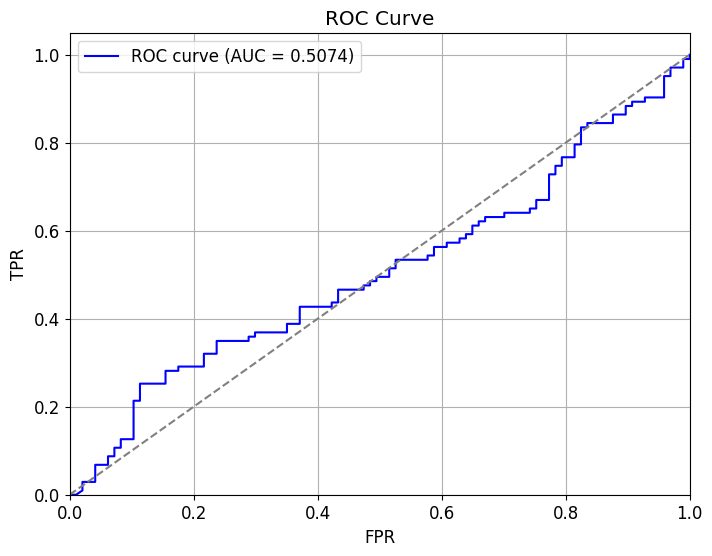

Test AUC-ROC score: 0.5074


In [26]:
# Training loop
num_epochs = 30
device = 'cpu'  # Set to 'cuda' if GPU available

# Training loop
for epoch in range(num_epochs):
    avg_loss, accuracy, auc_score, _, _ = model_synth.train_epoch(train_loader_synth, auc_track = True)
    if (epoch+1)%6 == 0:
        print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, AUC-ROC score: {auc_score:.4f}")

# Testing
# avg_test_loss, avg_test_accuracy = model_synth.test(test_loader_synth)
# print(f"\nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%")
auc_roc_score, _, _, _ = model_synth.evaluate_auc(test_loader_synth)
print(f"Test AUC-ROC score: {auc_roc_score:.4f}")

As expected, we find an AUC-ROC score of around 50%, and the ROC curve follows the diagonal quite closely. As a reminder, diagonal of the ROC curve represents the performance of a random classification model that makes predictions purely by chance.

Now we proceed to using our framework to analyse the waveform data from before.
## Section 3: Applying a 1D CNN to Waveform data

Let us load back in the waveform data. In the interest of comparison to ref., we will train the model for 50 epochs with a batch size of 256 (already set this before) on 12302 training signal waveforms, with an initial learning rate of 0.001.

In [27]:
trainset = Waveforms1D(xtrain, ytrain)
testset = Waveforms1D(xtest, ytest)

batch_size = 256 # Can change

trainloader = DataLoader(trainset, batch_size = batch_size,
                         shuffle = True, num_workers = 2)
testloader = DataLoader(testset, batch_size = batch_size,
                         shuffle = False, num_workers = 2)

To simplify things, and for later comparison, we will start by constructing the model presented in ref. as a baseline. We will use this on the waveform training data for a number of epochs and test its performance on the testing data. The only difference (as far as we can tell) is the inclusion of Dropout (with probability 0.5) in our implementation, which do not seem to be used in the model in ref.

In [28]:
# Number of features (input length)
input_length = 1000

# Set model configuration, as in ref.
layers_config = [
    {'type': 'conv', 'in_channels': 1, 'out_channels': 7, 'kernel_size': 10, 'padding':4},
    {'type': 'pool', 'kernel_size': 2},
    {'type': 'conv', 'in_channels': 7, 'out_channels': 14, 'kernel_size': 10, 'padding': 4},
    {'type': 'pool', 'kernel_size': 2}
]

fc_layers_config = [
    {'in_features': None, 'out_features': 64},
]

# Initialize the model
model_base = WF1D_CNN(input_length = input_length, 
                 layers_config = layers_config, 
                 fc_layers_config = fc_layers_config)

# Set loss function and optmizer
model_base.set_loss_fn(torch.nn.BCELoss())
model_base.set_optimizer(torch.optim.Adam, lr = 0.001)

### 3A. Model Training

Now, let us train and test the model on the data. We will also look at the other parameters of the model that we have tracked throughout the training process, such as weights and biases, as well as their gradients. Recall that we have set a constant learning rate so tracking this is not necessary.

In [29]:
# Training loop
avg_loss_list = np.zeros(50)
acc_list = np.zeros(50)
auc_score_list = np.zeros(50)

num_epochs = 50
start_time = time.time()
for epoch in range(num_epochs):
    avg_loss, accuracy, auc_score, all_gradients, all_weights = model_base.train_epoch(trainloader, auc_track = True)
    avg_loss_list[epoch], acc_list[epoch], auc_score_list[epoch] = avg_loss, accuracy, auc_score 
    if (epoch+1)%5 == 0:
        print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, AUC-ROC score: {auc_score:.4f}")
print(f'Training time: {round(time.time()-start_time, 2)} seconds')

Epoch 5, Training Loss: 0.1013, Accuracy: 0.9799, AUC-ROC score: 0.9952
Epoch 10, Training Loss: 0.0709, Accuracy: 0.9840, AUC-ROC score: 0.9959
Epoch 15, Training Loss: 0.0623, Accuracy: 0.9821, AUC-ROC score: 0.9959
Epoch 20, Training Loss: 0.0461, Accuracy: 0.9872, AUC-ROC score: 0.9970
Epoch 25, Training Loss: 0.0445, Accuracy: 0.9897, AUC-ROC score: 0.9980
Epoch 30, Training Loss: 0.0330, Accuracy: 0.9933, AUC-ROC score: 0.9987
Epoch 35, Training Loss: 0.0241, Accuracy: 0.9946, AUC-ROC score: 0.9994
Epoch 40, Training Loss: 0.0151, Accuracy: 0.9971, AUC-ROC score: 0.9998
Epoch 45, Training Loss: 0.0091, Accuracy: 0.9989, AUC-ROC score: 1.0000
Epoch 50, Training Loss: 0.0029, Accuracy: 0.9999, AUC-ROC score: 1.0000
Training time: 161.19 seconds


Let us visualise how the loss, accuracy, and AUC score varied during training:

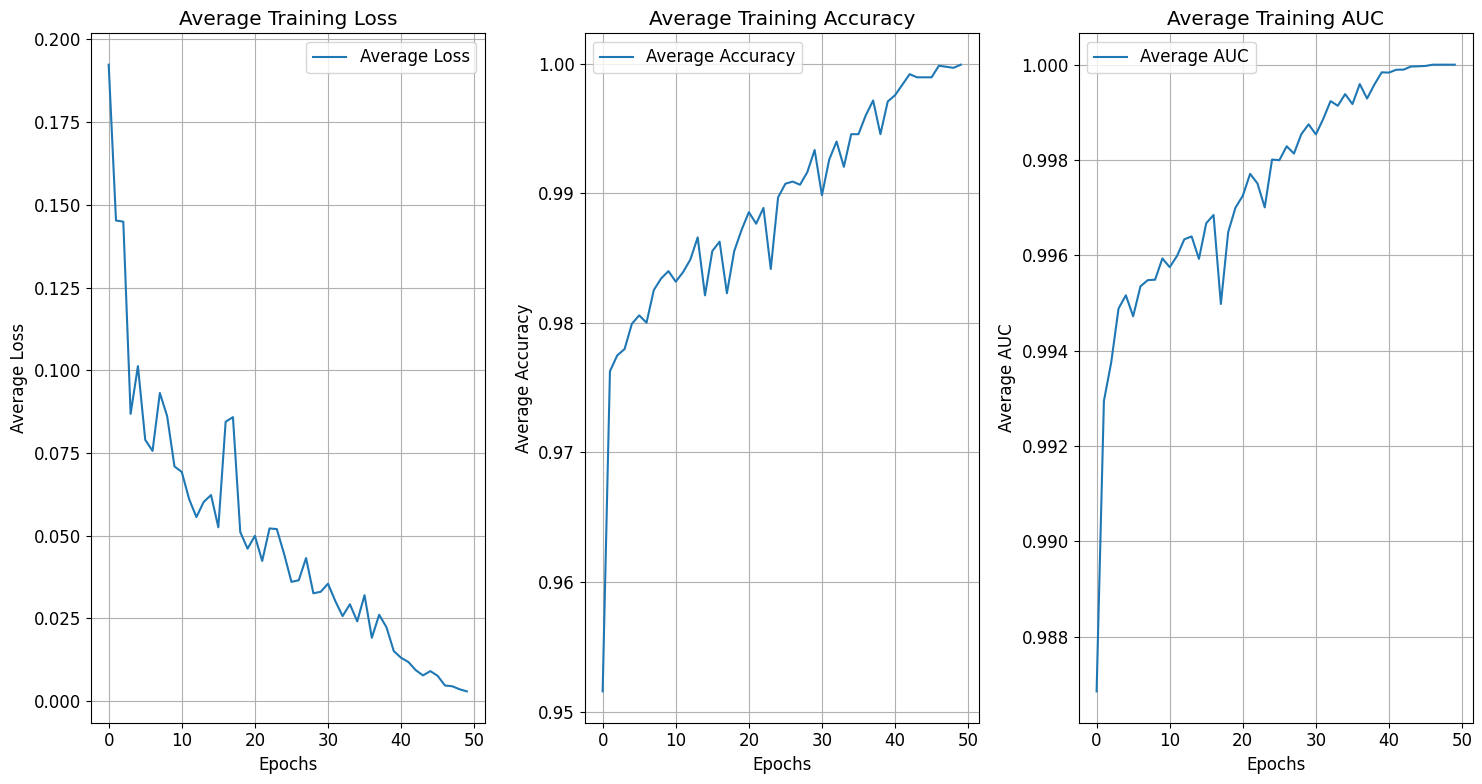

In [30]:
fig, axs = plt.subplots(1,3, figsize = (15, 8))
axs[0].plot(avg_loss_list, label = 'Average Loss')
axs[0].set_title('Average Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Average Loss')
axs[0].legend(loc='best')
axs[0].grid(True)

axs[1].plot(acc_list, label = 'Average Accuracy')
axs[1].set_title('Average Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Average Accuracy')
axs[1].legend(loc='best')
axs[1].grid(True)

axs[2].plot(auc_score_list, label = 'Average AUC')
axs[2].set_title('Average Training AUC')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Average AUC')
axs[2].legend(loc='best')
axs[2].grid(True)

plt.tight_layout()
plt.show()

Let us save this trained model along with the optimizer state:

In [31]:
torch.save({
    'model_base_state_dict': model_base.state_dict(),
    'optimizer_base_state_dict': model_base.optimizer.state_dict(),
}, "model_base_checkpoint.pth")

### 3B. Layer Weights and Biases, and their Gradients

Let us visualise the weights and biases of the layers of this network and their respective gradients throughout training. The titles of the plots here can seem a bit confusing, but the numbering here corresponds to the ordering of the layers in the network itself, and the prefix refers to whether the layer is from the conv.+pool part of the network ('cp_layers'), or the fully-connected part of the network ('fc_layers').

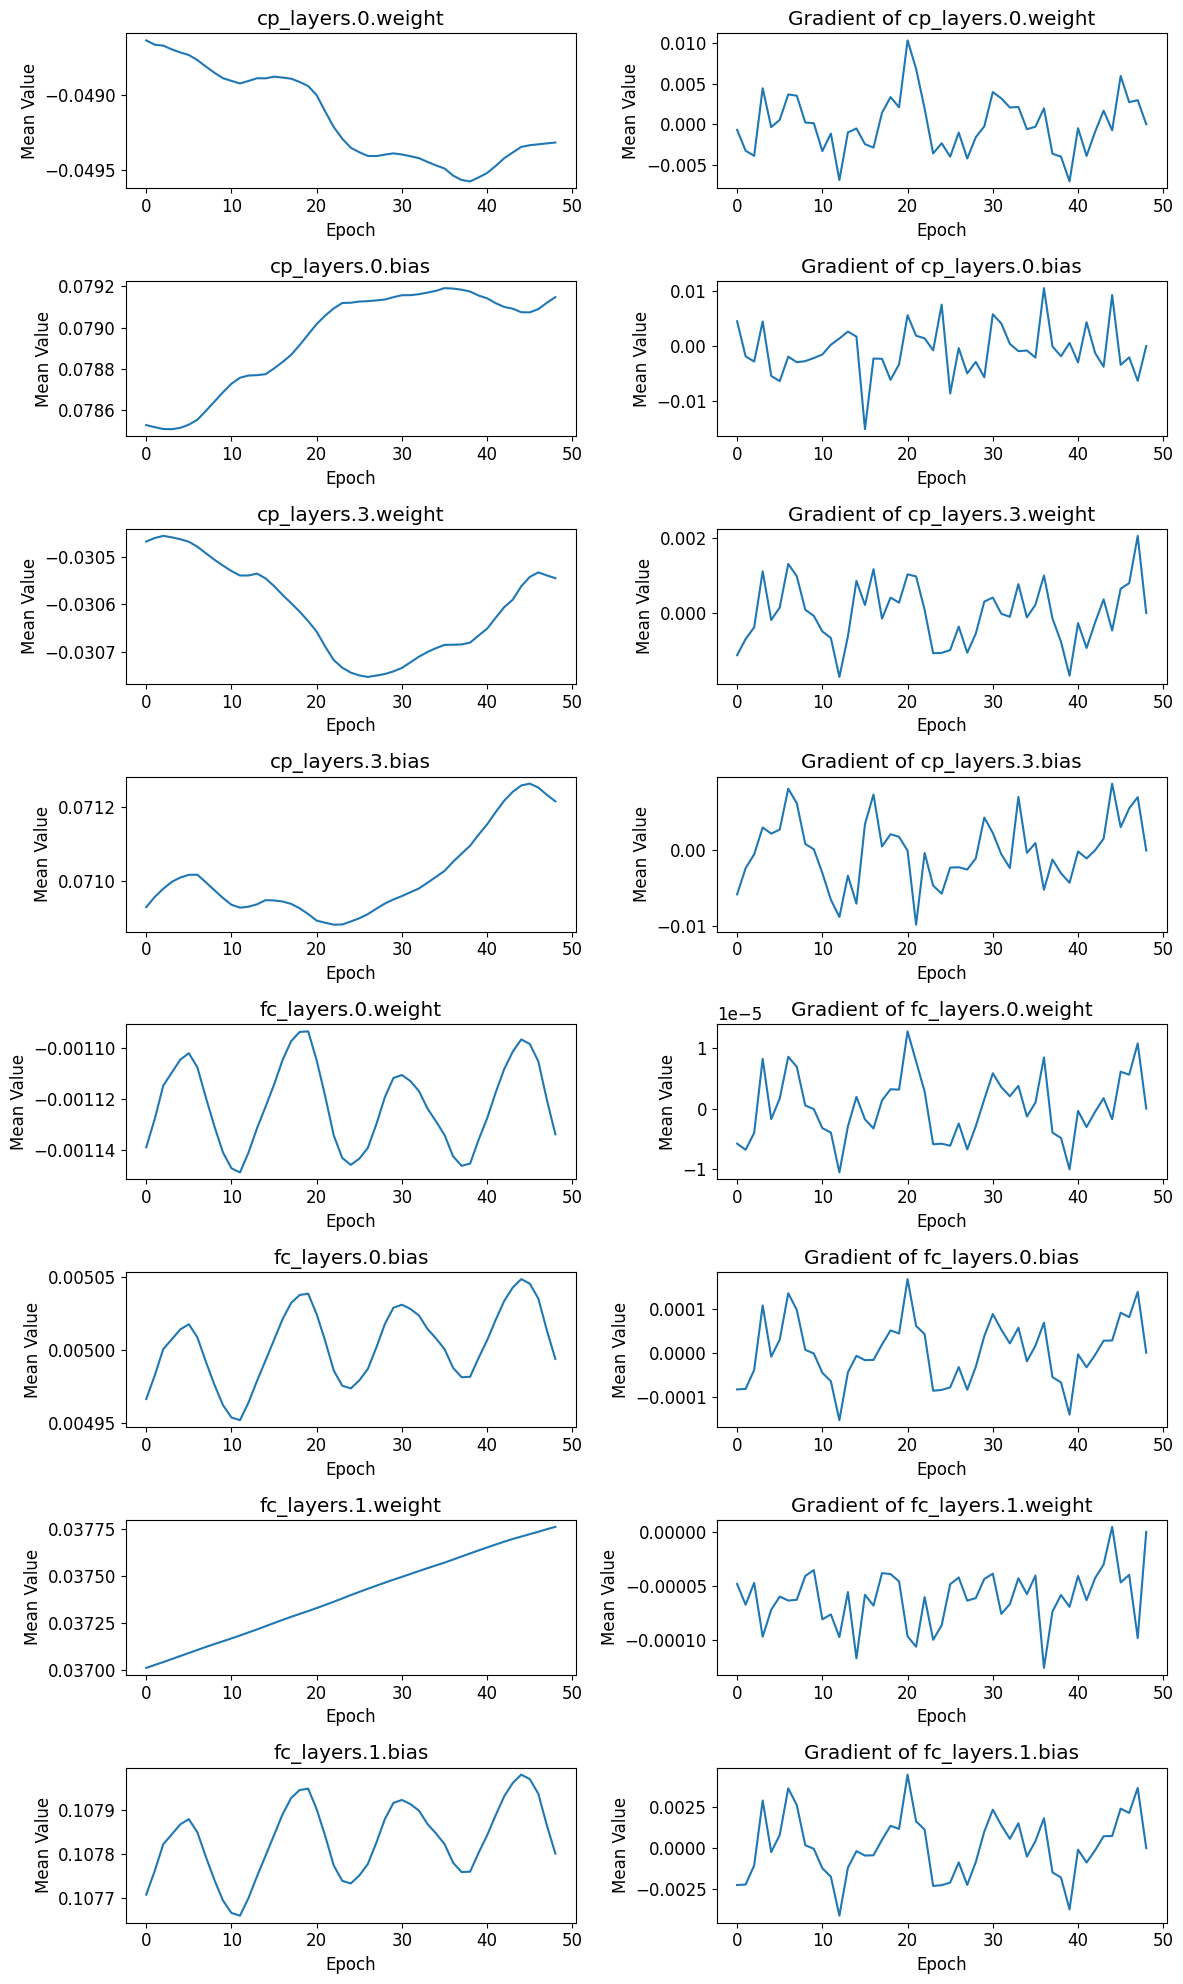

In [32]:
grad_mean_vals = {param_name: [] for param_name in all_gradients[0].keys()}
weight_mean_vals = {param_name: [] for param_name in all_weights[0].keys()}

for epoch_grad, epoch_weight in zip(all_gradients, all_weights):
    for param_name in epoch_grad.keys():
        grad_mean_vals[param_name].append(epoch_grad[param_name])
        weight_mean_vals[param_name].append(epoch_weight[param_name])
fig, ax = plt.subplots(len(grad_mean_vals), 2, figsize=(12, 20))
ax = ax.flatten()

for index, (key, _) in enumerate(grad_mean_vals.items()):
    ax[2 * index].plot(weight_mean_vals[key])
    ax[2 * index].set_title(f"{key}")
    ax[2 * index].set_xlabel("Epoch")
    ax[2 * index].set_ylabel("Mean Value")
    
    ax[2 * index + 1].plot(grad_mean_vals[key])
    ax[2 * index + 1].set_title(f"Gradient of {key}")
    ax[2 * index + 1].set_xlabel("Epoch")
    ax[2 * index + 1].set_ylabel("Mean Value")

plt.tight_layout()

plt.show()

The above information is mostly for technical interest, but we include it here for completeness. We note that the parameters of the model have generally stabilized during training, with the exception of the weights in the last fully-connected layer, which seem to vary, but very slowly, suggesting that the model is approaching convergence. This could indicate that the model has largely learned the relevant features, while the final layer is still adapting to fine-tune the predictions.

### 3C. Testing and Model Evaluation

Now let us test the model on the testing set:

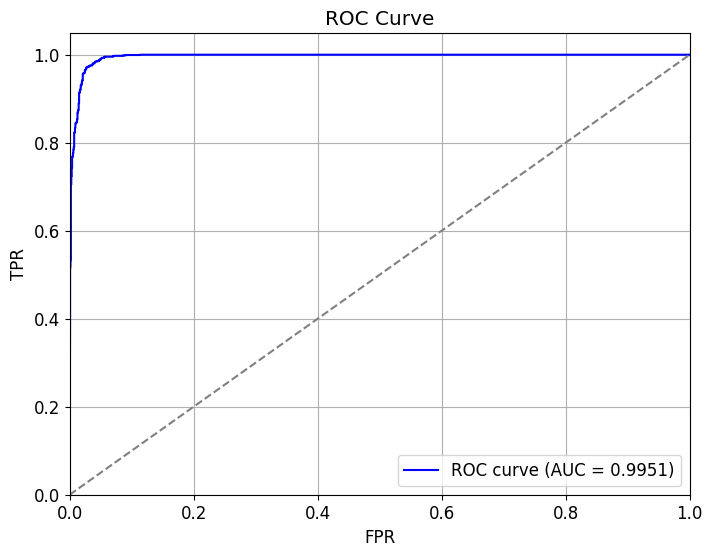

Test AUC-ROC score: 0.9951


In [33]:
# AUC-ROC
auc_roc_score, _, _, _ = model_base.evaluate_auc(testloader)
print(f"Test AUC-ROC score: {auc_roc_score:.4f}")

The model from ref. has managed to achieve, as expected, an AUC-ROC score of >99%, which was one of the objectives of our analysis.

We can be even more thorough, and evaluate the model on different randomized samples from the test set. This will allow us to calulate the AUC-ROC score and ROC curve with an uncertainty on the calculation. We will try to replicate Figure 5 and the results in Table 2 from ref.

Let us define a function that generates randomized samples from a given dataset. We will also define a function to interpolate the ROC curves to ensure all of them have the same number of points. This will help us in calculations and plotting.

In [34]:
def randomized_subset(dataset, batch_size, sample_size=0.1):
    """
    Create a random subset dataloader by sampling a fraction of the dataset.

    Parameters:
    - dataset (torch.utils.data.Dataset): The test dataset.
    - batch_size (int): Batch size to use in the dataloader.
    - sample_size (float): Proportion of the dataset to sample (between 0 and 1).

    Returns:
    - DataLoader: A dataloader for the random subset of the dataset.
    """
    # Determine the number of samples to draw
    num_samples = int(len(dataset) * sample_size)
    
    # Randomly sample indices
    indices = torch.randperm(len(dataset))[:num_samples]
    
    # Create a sampler and dataloader
    sampler = SubsetRandomSampler(indices)
    return DataLoader(dataset, batch_size = batch_size, sampler = sampler)

def interpolate_roc(fpr_list, tpr_list, num_points=100):
    """
    Interpolate the ROC curves to ensure all have the same number of points.
    
    Parameters:
    - fpr_list (list of np.array): List of false positive rates from multiple samples.
    - tpr_list (list of np.array): List of true positive rates from multiple samples.
    - num_points (int): Number of points to use in the interpolated ROC curve.
    
    Returns:
    - interp_fpr (np.array): Interpolated false positive rates.
    - interp_tpr (np.array): Interpolated true positive rates.
    """
    # Define the common set of FPR points
    mean_fpr = np.linspace(0, 1, num_points)
    
    # Interpolate each sample's TPR to the common FPR points
    interp_tpr = np.array([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)])
    
    return mean_fpr, interp_tpr

The following cell generate a ROC curve similar to that in Figure 5 of ref. and also the mean AUC-ROC score with uncertainty.

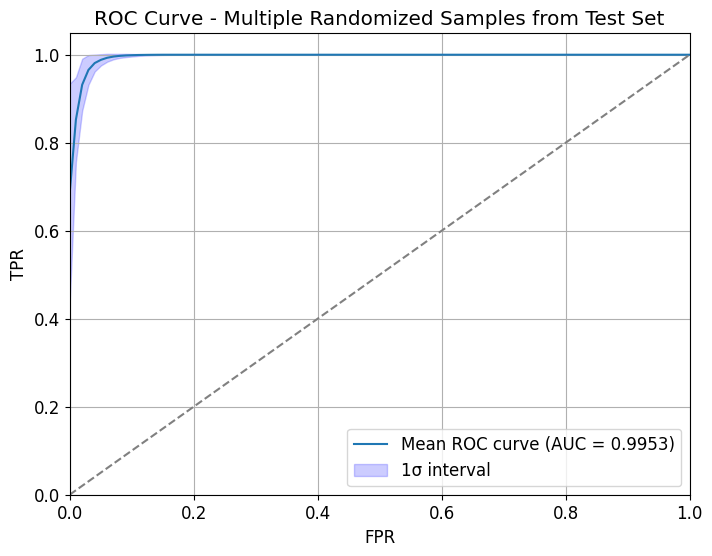

Mean AUC Score: 0.9953, uncertainty (±1σ): 0.0027


In [35]:
# Collecting FPR, TPR, and AUC scores from multiple evaluations
fpr_list = []
tpr_list = []
auc_scores = []

batch_size = 256
num_samples = 1000

for _ in range(num_samples):
    random_dataloader = randomized_subset(testset, batch_size, sample_size=0.1)
    
    auc_score, fpr, tpr, _ = model_base.evaluate_auc(random_dataloader, device='cpu', plot=False)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_scores.append(auc_score)

mean_fpr, interp_tpr = interpolate_roc(fpr_list, tpr_list, num_points=100)

mean_tpr = np.mean(interp_tpr, axis=0)
std_tpr = np.std(interp_tpr, axis=0)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

plt.figure(figsize=(8, 6))
line, = plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC curve (AUC = {mean_auc:.4f})')

plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2, label='1σ interval')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - Multiple Randomized Samples from Test Set')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print(f"Mean AUC Score: {mean_auc:.4f}, uncertainty (±1σ): {std_auc:.4f}")

So we have managed to achieve a score with uncertainty similar to that presented in ref.

### 3D. Feature Maps 
Using representative examples of each waveform type, let us visualise the feature maps from the trained model for each type of waveform to understand how the trained model is transforming the original data and extracting relevant information from it. We will try to replicate some aspects of Figure 6 from ref.

Feature maps for waveform type 0


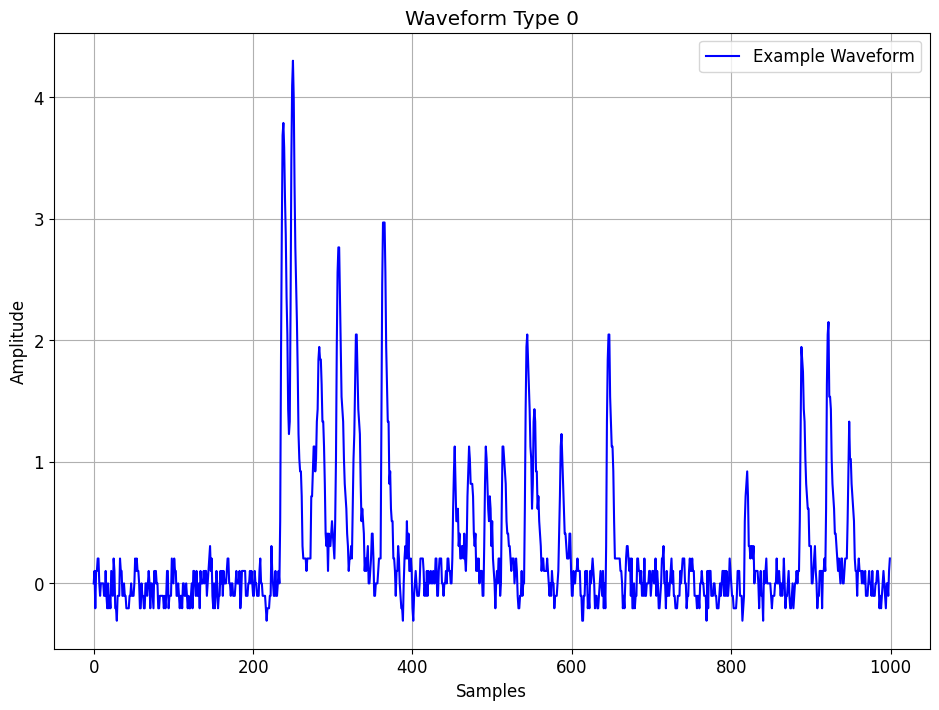

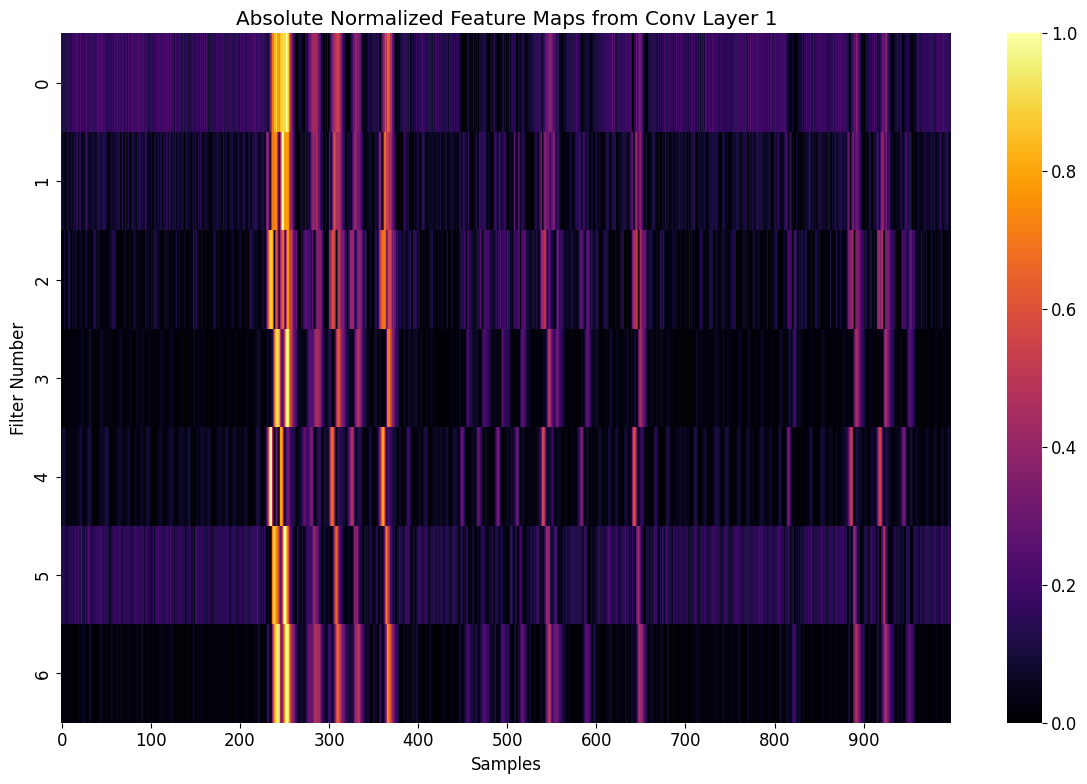

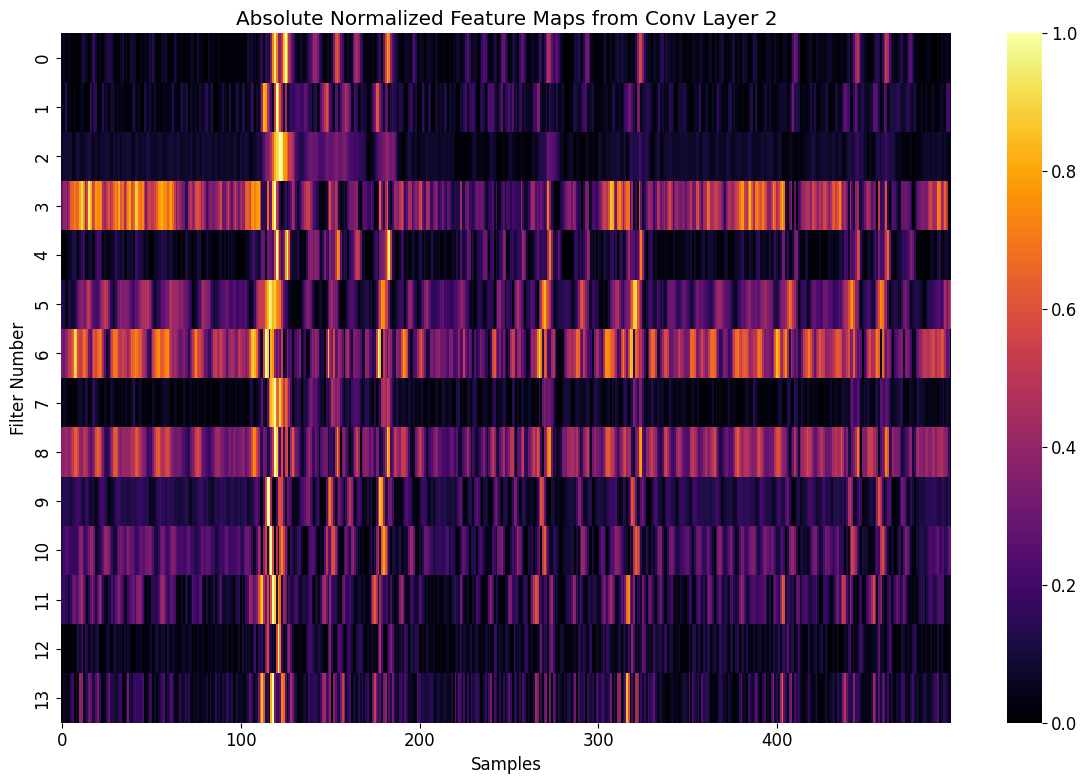



Feature maps for waveform type 1


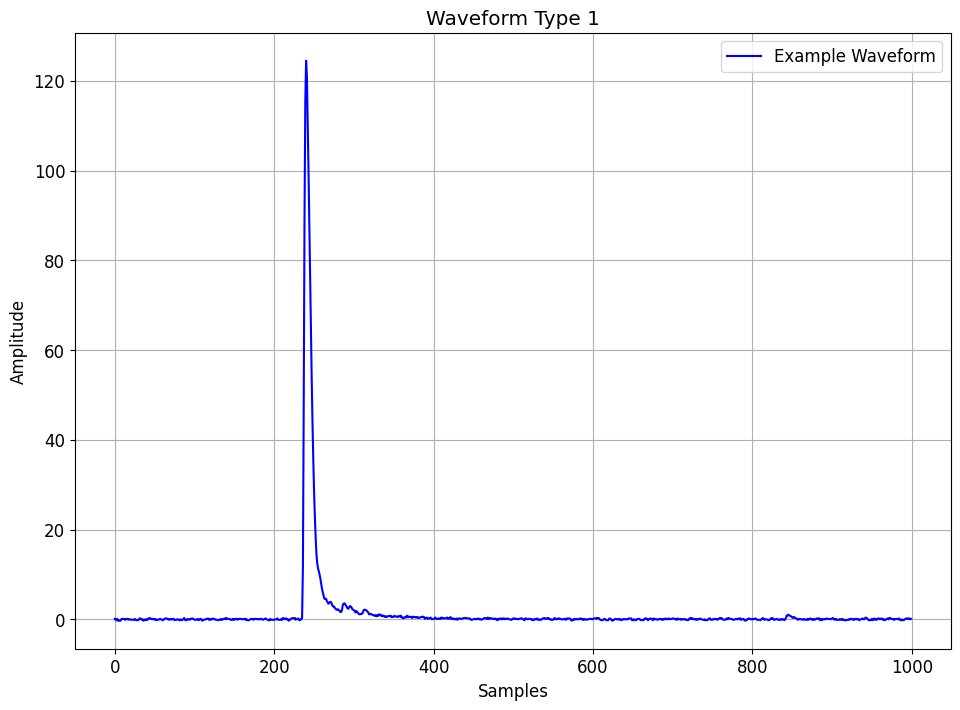

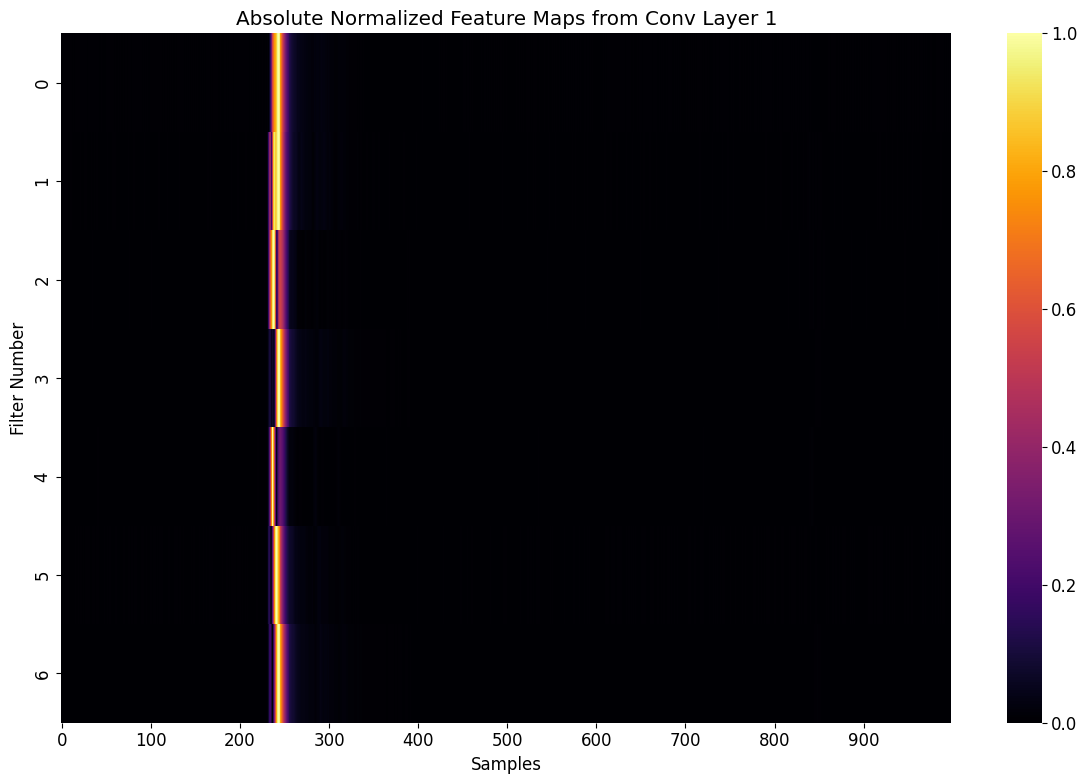

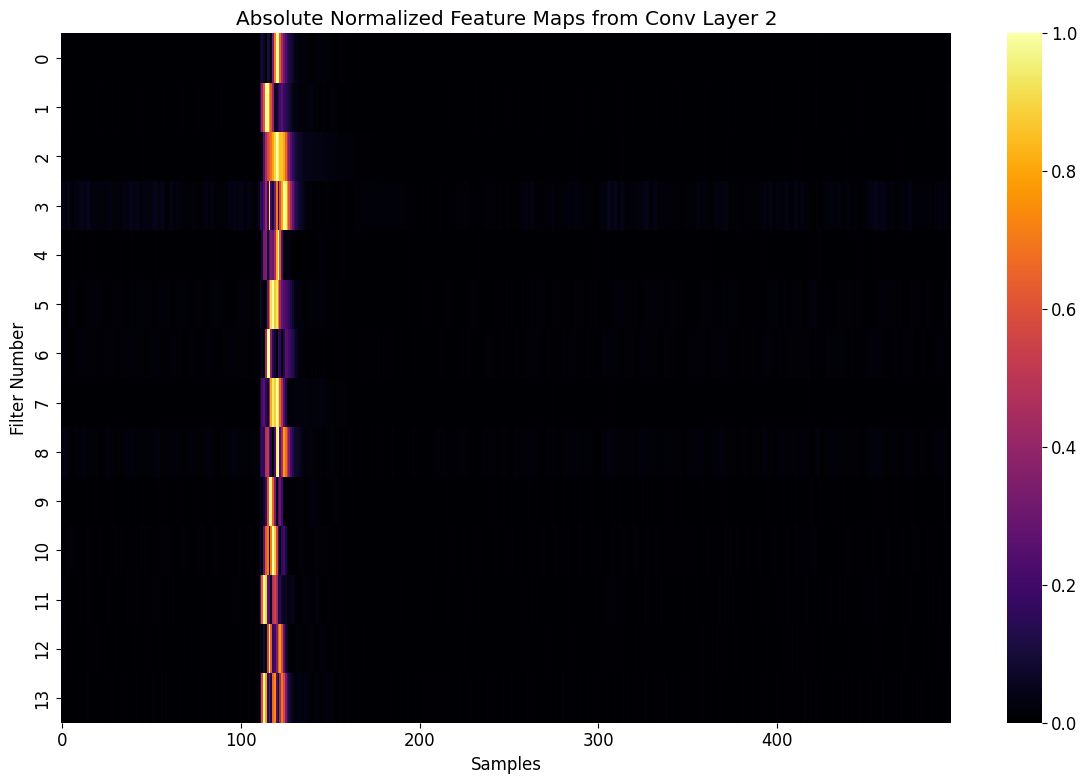

In [36]:
labels = ytrain[:,0] # Choose first entry of one-hot label vectors
unique_labels = np.unique(labels)
for unique_label in unique_labels:
    print(f'Feature maps for waveform type {int(unique_label)}')
    indices = np.where(labels == unique_label)
    waveforms = xtrain[indices]
    example_waveform = waveforms[np.random.randint(0, len(waveforms))]
    plt.figure(figsize = (11.3,8))
    plt.plot(example_waveform, label='Example Waveform', color='blue', alpha = 1)
    plt.title(f'Waveform Type {int(unique_label)}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    example_waveform_tensor = torch.from_numpy(example_waveform).float().unsqueeze(0).unsqueeze(1)
    model_base.forward(example_waveform_tensor, plot_feature_maps=True)
    print('\n')

We have attempted to visualise the feature maps as 2D heatmaps, where the colour represents the absolute normalized filter activation for each layer. Darker colours indicate lower absolute activation, while lighter colours signify higher activation.

To understand these maps, recall that a CNN learns filters during training, each designed to detect specific patterns or features in the input. A lighter region in a filter’s activation indicates the presence of a feature matching the filter’s learned weights, such as spikes, periodic signals, or characteristic waveforms. Conversely, darker regions suggest that the corresponding feature is absent or weak in that part of the input sequence.

The first layer’s behaviour is relatively straightforward to interpret. For example, filter 4 strongly activates at signal maxima, as evidenced by its narrow, high-intensity regions at global and local maxima. This suggests that filter 4 effectively identifies peak counts and their relative amplitudes against the background. In contrast, filters 0 and 6 activate around the peaks, likely capturing the steepness and local neighbourhood of the peaks to distinguish between signal types.

While our interpretation aligns for the most part with the general findings in ref., some filters behave differently from those in ref., possibly due to subtle model configuration or heatmap generation differences. However, the model’s ability to discriminate between signal types remains unaffected.

Now, we can proceed to experiment with a few model configurations and see if we find significant improvements in performance over the baseline model from ref.

## Section 4: Experiments with Various Models

To streamline the investigation in this section, we will define an `exe()` function that automatically runs the steps of the analysis to yield the final AUC score with uncertainty and the associated ROC curve:

In [46]:
def exe(model, num_epochs = 50, test_batch_size = 256, test_num_samples = 1000):
    """
    A function to sequentially run the steps of the analysis to streamline
    the implementation of several models. The code is essentially copy-pasted from
    above, with only minor changes.

    Parameters:
    - model (nn.Module): A CNN model initialized externally.
    - num_epochs (int): Number of training epochs for the model. Default is 50, as before.
    - test_batch_size (int): Number of waveforms from test set for model evaluation. Default is 256, as before.
    - test_num_samples (int): Number of times the test set is sampled. Default is 1000, as before.

    Outputs:
    - Mean AUC score, and standard deviation. Also return the mean FPR and mean TPR and its standard deviation
    for ROC curve plotting.
    """
    start_time = time.time()
    for epoch in range(num_epochs):
        avg_loss, accuracy, auc_score, _, _ = model.train_epoch(trainloader, auc_track = True)
        if (epoch+1)%5 == 0:
            print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, AUC-ROC score: {auc_score:.4f}")
    print(f'Training time: {round(time.time()-start_time, 2)} seconds')
    fpr_list = []
    tpr_list = []
    auc_scores = []
    
    for _ in range(test_num_samples):
        random_dataloader = randomized_subset(testset, test_batch_size, sample_size=0.1)
        
        auc_score, fpr, tpr, _ = model.evaluate_auc(random_dataloader, device='cpu', plot=False)
        
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_scores.append(auc_score)
    
    mean_fpr, interp_tpr = interpolate_roc(fpr_list, tpr_list, num_points=100)
    
    mean_tpr = np.mean(interp_tpr, axis=0)
    std_tpr = np.std(interp_tpr, axis=0)
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    return mean_fpr, mean_tpr, std_tpr, mean_auc, std_auc

For brevity, we will only consider three further models, each with the following structural choices:
- Model 1: 1 **fewer** conv. + pool layer combination
- Model 2: 1 **extra** conv. + pool layer combination, with a smaller kernel size
- Model 3: 1 **extra** fully-connected layer with 32 neurons

We will also adjust the the kernel sizes and paddings for the layers of the model such that the length of the signal remains unchanged when passing through a conv. layer. We can calculate the required adjusted values using the formula we quoted earlier.

Let us define these models:

In [47]:
## Model 1
input_length = 1000

layers_config = [
    {'type': 'conv', 'in_channels': 1, 'out_channels': 7, 'kernel_size': 5, 'padding':2},
    {'type': 'pool', 'kernel_size': 2},
]

fc_layers_config = [
    {'in_features': None, 'out_features': 64},
]

model_1 = WF1D_CNN(input_length = input_length, 
                 layers_config = layers_config, 
                 fc_layers_config = fc_layers_config)

model_1.set_loss_fn(torch.nn.BCELoss())
model_1.set_optimizer(torch.optim.Adam, lr = 0.001)

In [48]:
## Model 2

input_length = 1000

layers_config = [
    {'type': 'conv', 'in_channels': 1, 'out_channels': 7, 'kernel_size': 5, 'padding':2},
    {'type': 'pool', 'kernel_size': 2},
    {'type': 'conv', 'in_channels': 7, 'out_channels': 14, 'kernel_size': 5, 'padding': 2},
    {'type': 'pool', 'kernel_size': 2},
    {'type': 'conv', 'in_channels': 14, 'out_channels': 28, 'kernel_size': 5, 'padding': 2},
    {'type': 'pool', 'kernel_size': 2}
]

fc_layers_config = [
    {'in_features': None, 'out_features': 64},
]

model_2 = WF1D_CNN(input_length = input_length, 
                 layers_config = layers_config, 
                 fc_layers_config = fc_layers_config)

model_2.set_loss_fn(torch.nn.BCELoss())
model_2.set_optimizer(torch.optim.Adam, lr = 0.001)

In [49]:
## Model 3

input_length = 1000

layers_config = [
    {'type': 'conv', 'in_channels': 1, 'out_channels': 7, 'kernel_size': 5, 'padding':2},
    {'type': 'pool', 'kernel_size': 2},
    {'type': 'conv', 'in_channels': 7, 'out_channels': 14, 'kernel_size': 5, 'padding': 2},
    {'type': 'pool', 'kernel_size': 2},
]

fc_layers_config = [
    {'in_features': None, 'out_features': 64},
    {'in_features': 64, 'out_features': 32},
    {'in_features': 32, 'out_features': 16}
]

model_3 = WF1D_CNN(input_length = input_length, 
                 layers_config = layers_config, 
                 fc_layers_config = fc_layers_config)

model_3.set_loss_fn(torch.nn.BCELoss())
model_3.set_optimizer(torch.optim.Adam, lr = 0.001)

In [41]:
mean_fpr_1, mean_tpr_1, std_tpr_1, mean_auc_1, std_auc_1 = exe(model_1)
torch.save({
    'model_1_state_dict': model_1.state_dict(),
    'optimizer_1_state_dict': model_1.optimizer.state_dict(),
}, "model_1_checkpoint.pth")

Epoch 5, Training Loss: 0.1174, Accuracy: 0.9783, AUC-ROC score: 0.9943
Epoch 10, Training Loss: 0.1583, Accuracy: 0.9815, AUC-ROC score: 0.9952
Epoch 15, Training Loss: 0.0930, Accuracy: 0.9804, AUC-ROC score: 0.9956
Epoch 20, Training Loss: 0.1608, Accuracy: 0.9829, AUC-ROC score: 0.9958
Epoch 25, Training Loss: 0.0990, Accuracy: 0.9847, AUC-ROC score: 0.9964
Epoch 30, Training Loss: 0.1630, Accuracy: 0.9849, AUC-ROC score: 0.9959
Epoch 35, Training Loss: 0.0819, Accuracy: 0.9875, AUC-ROC score: 0.9972
Epoch 40, Training Loss: 0.1155, Accuracy: 0.9893, AUC-ROC score: 0.9970
Epoch 45, Training Loss: 0.1174, Accuracy: 0.9924, AUC-ROC score: 0.9974
Epoch 50, Training Loss: 0.0994, Accuracy: 0.9933, AUC-ROC score: 0.9976
Training time: 152.16 seconds


In [42]:
mean_fpr_2, mean_tpr_2, std_tpr_2, mean_auc_2, std_auc_2 = exe(model_2)
torch.save({
    'model_2_state_dict': model_2.state_dict(),
    'optimizer_2_state_dict': model_2.optimizer.state_dict(),
}, "model_2_checkpoint.pth")

Epoch 5, Training Loss: 0.0896, Accuracy: 0.9788, AUC-ROC score: 0.9949
Epoch 10, Training Loss: 0.0683, Accuracy: 0.9817, AUC-ROC score: 0.9952
Epoch 15, Training Loss: 0.0548, Accuracy: 0.9845, AUC-ROC score: 0.9967
Epoch 20, Training Loss: 0.0533, Accuracy: 0.9865, AUC-ROC score: 0.9969
Epoch 25, Training Loss: 0.0485, Accuracy: 0.9865, AUC-ROC score: 0.9971
Epoch 30, Training Loss: 0.0463, Accuracy: 0.9880, AUC-ROC score: 0.9979
Epoch 35, Training Loss: 0.0372, Accuracy: 0.9898, AUC-ROC score: 0.9981
Epoch 40, Training Loss: 0.0462, Accuracy: 0.9911, AUC-ROC score: 0.9988
Epoch 45, Training Loss: 0.0261, Accuracy: 0.9933, AUC-ROC score: 0.9992
Epoch 50, Training Loss: 0.0229, Accuracy: 0.9938, AUC-ROC score: 0.9995
Training time: 211.15 seconds


In [43]:
mean_fpr_3, mean_tpr_3, std_tpr_3, mean_auc_3, std_auc_3 = exe(model_3)
torch.save({
    'model_3_state_dict': model_3.state_dict(),
    'optimizer_3_state_dict': model_3.optimizer.state_dict(),
}, "model_3_checkpoint.pth")

Epoch 5, Training Loss: 0.0812, Accuracy: 0.9782, AUC-ROC score: 0.9939
Epoch 10, Training Loss: 0.0799, Accuracy: 0.9807, AUC-ROC score: 0.9953
Epoch 15, Training Loss: 0.0603, Accuracy: 0.9816, AUC-ROC score: 0.9954
Epoch 20, Training Loss: 0.0566, Accuracy: 0.9854, AUC-ROC score: 0.9974
Epoch 25, Training Loss: 0.0462, Accuracy: 0.9872, AUC-ROC score: 0.9979
Epoch 30, Training Loss: 0.0415, Accuracy: 0.9899, AUC-ROC score: 0.9981
Epoch 35, Training Loss: 0.0389, Accuracy: 0.9903, AUC-ROC score: 0.9990
Epoch 40, Training Loss: 0.0323, Accuracy: 0.9934, AUC-ROC score: 0.9990
Epoch 45, Training Loss: 0.0294, Accuracy: 0.9944, AUC-ROC score: 0.9994
Epoch 50, Training Loss: 0.0284, Accuracy: 0.9948, AUC-ROC score: 0.9994
Training time: 231.15 seconds


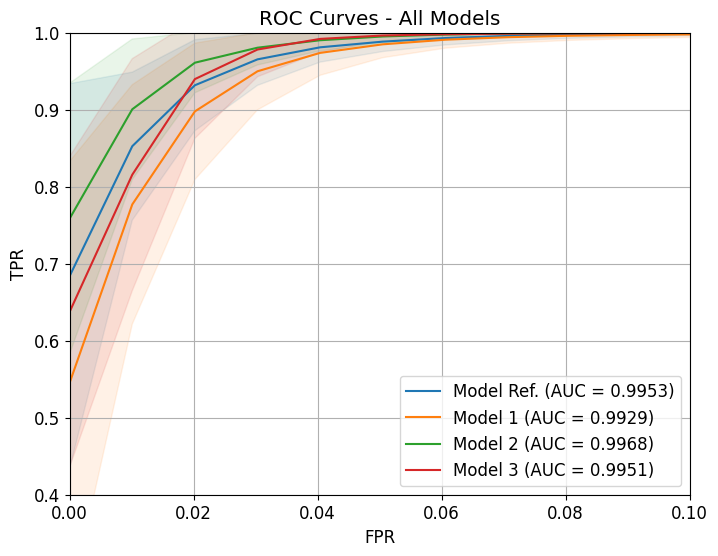

,Mean AUC,Std AUC
Model,,
Ref.,0.9953,0.0027
Model 1,0.9929,0.0041
Model 2,0.9968,0.0021
Model 3,0.9951,0.0031


In [44]:
plt.figure(figsize=(8, 6))
line, = plt.plot(mean_fpr, mean_tpr, label=f'Model Ref. (AUC = {mean_auc:.4f})')
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color=line.get_color(), alpha=0.1)

line1, = plt.plot(mean_fpr_1, mean_tpr_1, label=f'Model 1 (AUC = {mean_auc_1:.4f})')
plt.fill_between(mean_fpr_1, mean_tpr_1 - std_tpr_1, mean_tpr_1 + std_tpr_1, color=line1.get_color(), alpha=0.1)

line2, = plt.plot(mean_fpr_2, mean_tpr_2, label=f'Model 2 (AUC = {mean_auc_2:.4f})')
plt.fill_between(mean_fpr_2, mean_tpr_2 - std_tpr_2, mean_tpr_2 + std_tpr_2, color=line2.get_color(), alpha=0.1)

line3, = plt.plot(mean_fpr_3, mean_tpr_3, label=f'Model 3 (AUC = {mean_auc_3:.4f})')
plt.fill_between(mean_fpr_3, mean_tpr_3 - std_tpr_3, mean_tpr_3 + std_tpr_3, color=line3.get_color(), alpha=0.1)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.ylim([0.4, 1.0])
plt.xlim([0.0, 0.1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves - All Models')
plt.legend(loc='best')
plt.grid(True)
plt.show()


results = {
    'Model': ['Ref.', 'Model 1', 'Model 2', 'Model 3'],
    'Mean AUC': [mean_auc, mean_auc_1, mean_auc_2, mean_auc_3],
    'Std AUC': [std_auc, std_auc_1, std_auc_2, std_auc_3]
}

df_auc_scores = pd.DataFrame(results).round(4)
df_auc_scores.set_index('Model', inplace = True)

display(df_auc_scores)

We find that both the model with the extra conv. + pool combination with smaller kernel sizes, outperformed the reference model, also showing smaller standard errors in their mean AUC scores, in this case.

Several factors could explain these improvements, including:

- An extra convolutional and pooling layer may enhance the network's ability to process increasingly abstract representations of the input data, improving feature extraction.
- The smaller kernel sizes could be aiding in picking up more fine-grain details in the signals that are aiding in identifying them.

We include a schematic of model 2 as a computational graph:

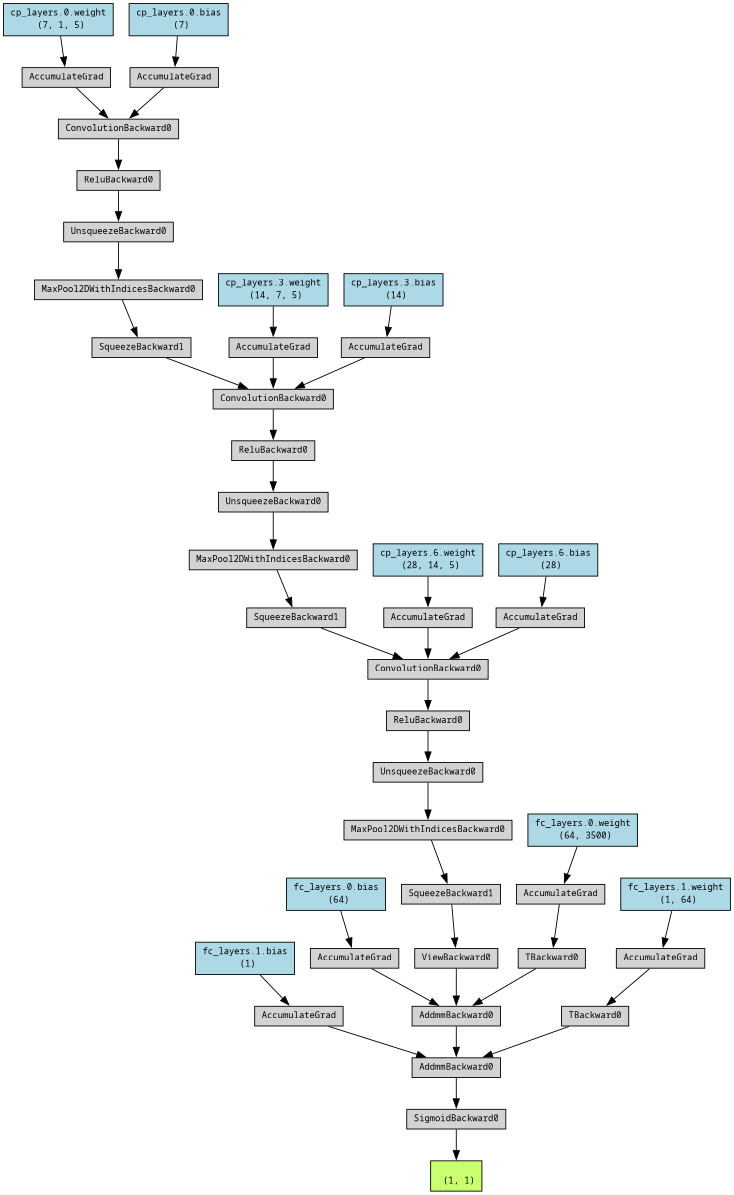

In [57]:
dummy_input = torch.randn(1, 1, 1000)

output = model_2.forward(dummy_input)

graph = make_dot(output, params=dict(model_2.named_parameters()))
graph.render("network_schematic", format="png")
Image(filename="network_schematic.png")

The computational graph above visualises the backpropagation process in our neural network, illustrating how gradients flow through the model to update parameters during training. Key elements of the graph are as follows:

1) **Parameter Layers**:

   - The network consists of two convolutional layers (cp_layers.0 and cp_layers.3) with their associated weights and biases, followed by two fully connected layers (fc_layers.0 and fc_layers.1).
    - The shapes of these parameter tensors indicate the number of filters, input/output channels, and kernel sizes for the convolutional layers, as well as the number of neurons in the fully connected layers.

2) **Gradient Flow**:
   - Gradients propagate backward from the final output layer, which has a shape of (1, 1) corresponding to a single binary classification output.
   - Key operations in the backpropagation include convolution (ConvolutionBackward0), pooling (MaxPool2DWithIndicesBackward0), ReLU activation (ReluBackward0), matrix multiplication in the fully connected layers (AddmmBackward0), and sigmoid activation (SigmoidBackward0).

3) **Intermediate Shapes**:
   - The shapes of the tensors at each stage of the network (e.g., (7, 1, 10) for the first convolutional layer weights) confirm the dimensionality transformations as data flows through the layers.
   - The pooling layers reduce the feature map dimensions, while the fully connected layers aggregate these features for classification.

4) **Model Output**:
   - The final output tensor is passed through a sigmoid activation function to produce a single probability score, indicating the likelihood of the input belonging to a particular class.
  
We also include an attempted sketch of the network. We took insipiration from Figure 4 of ref. while making this:


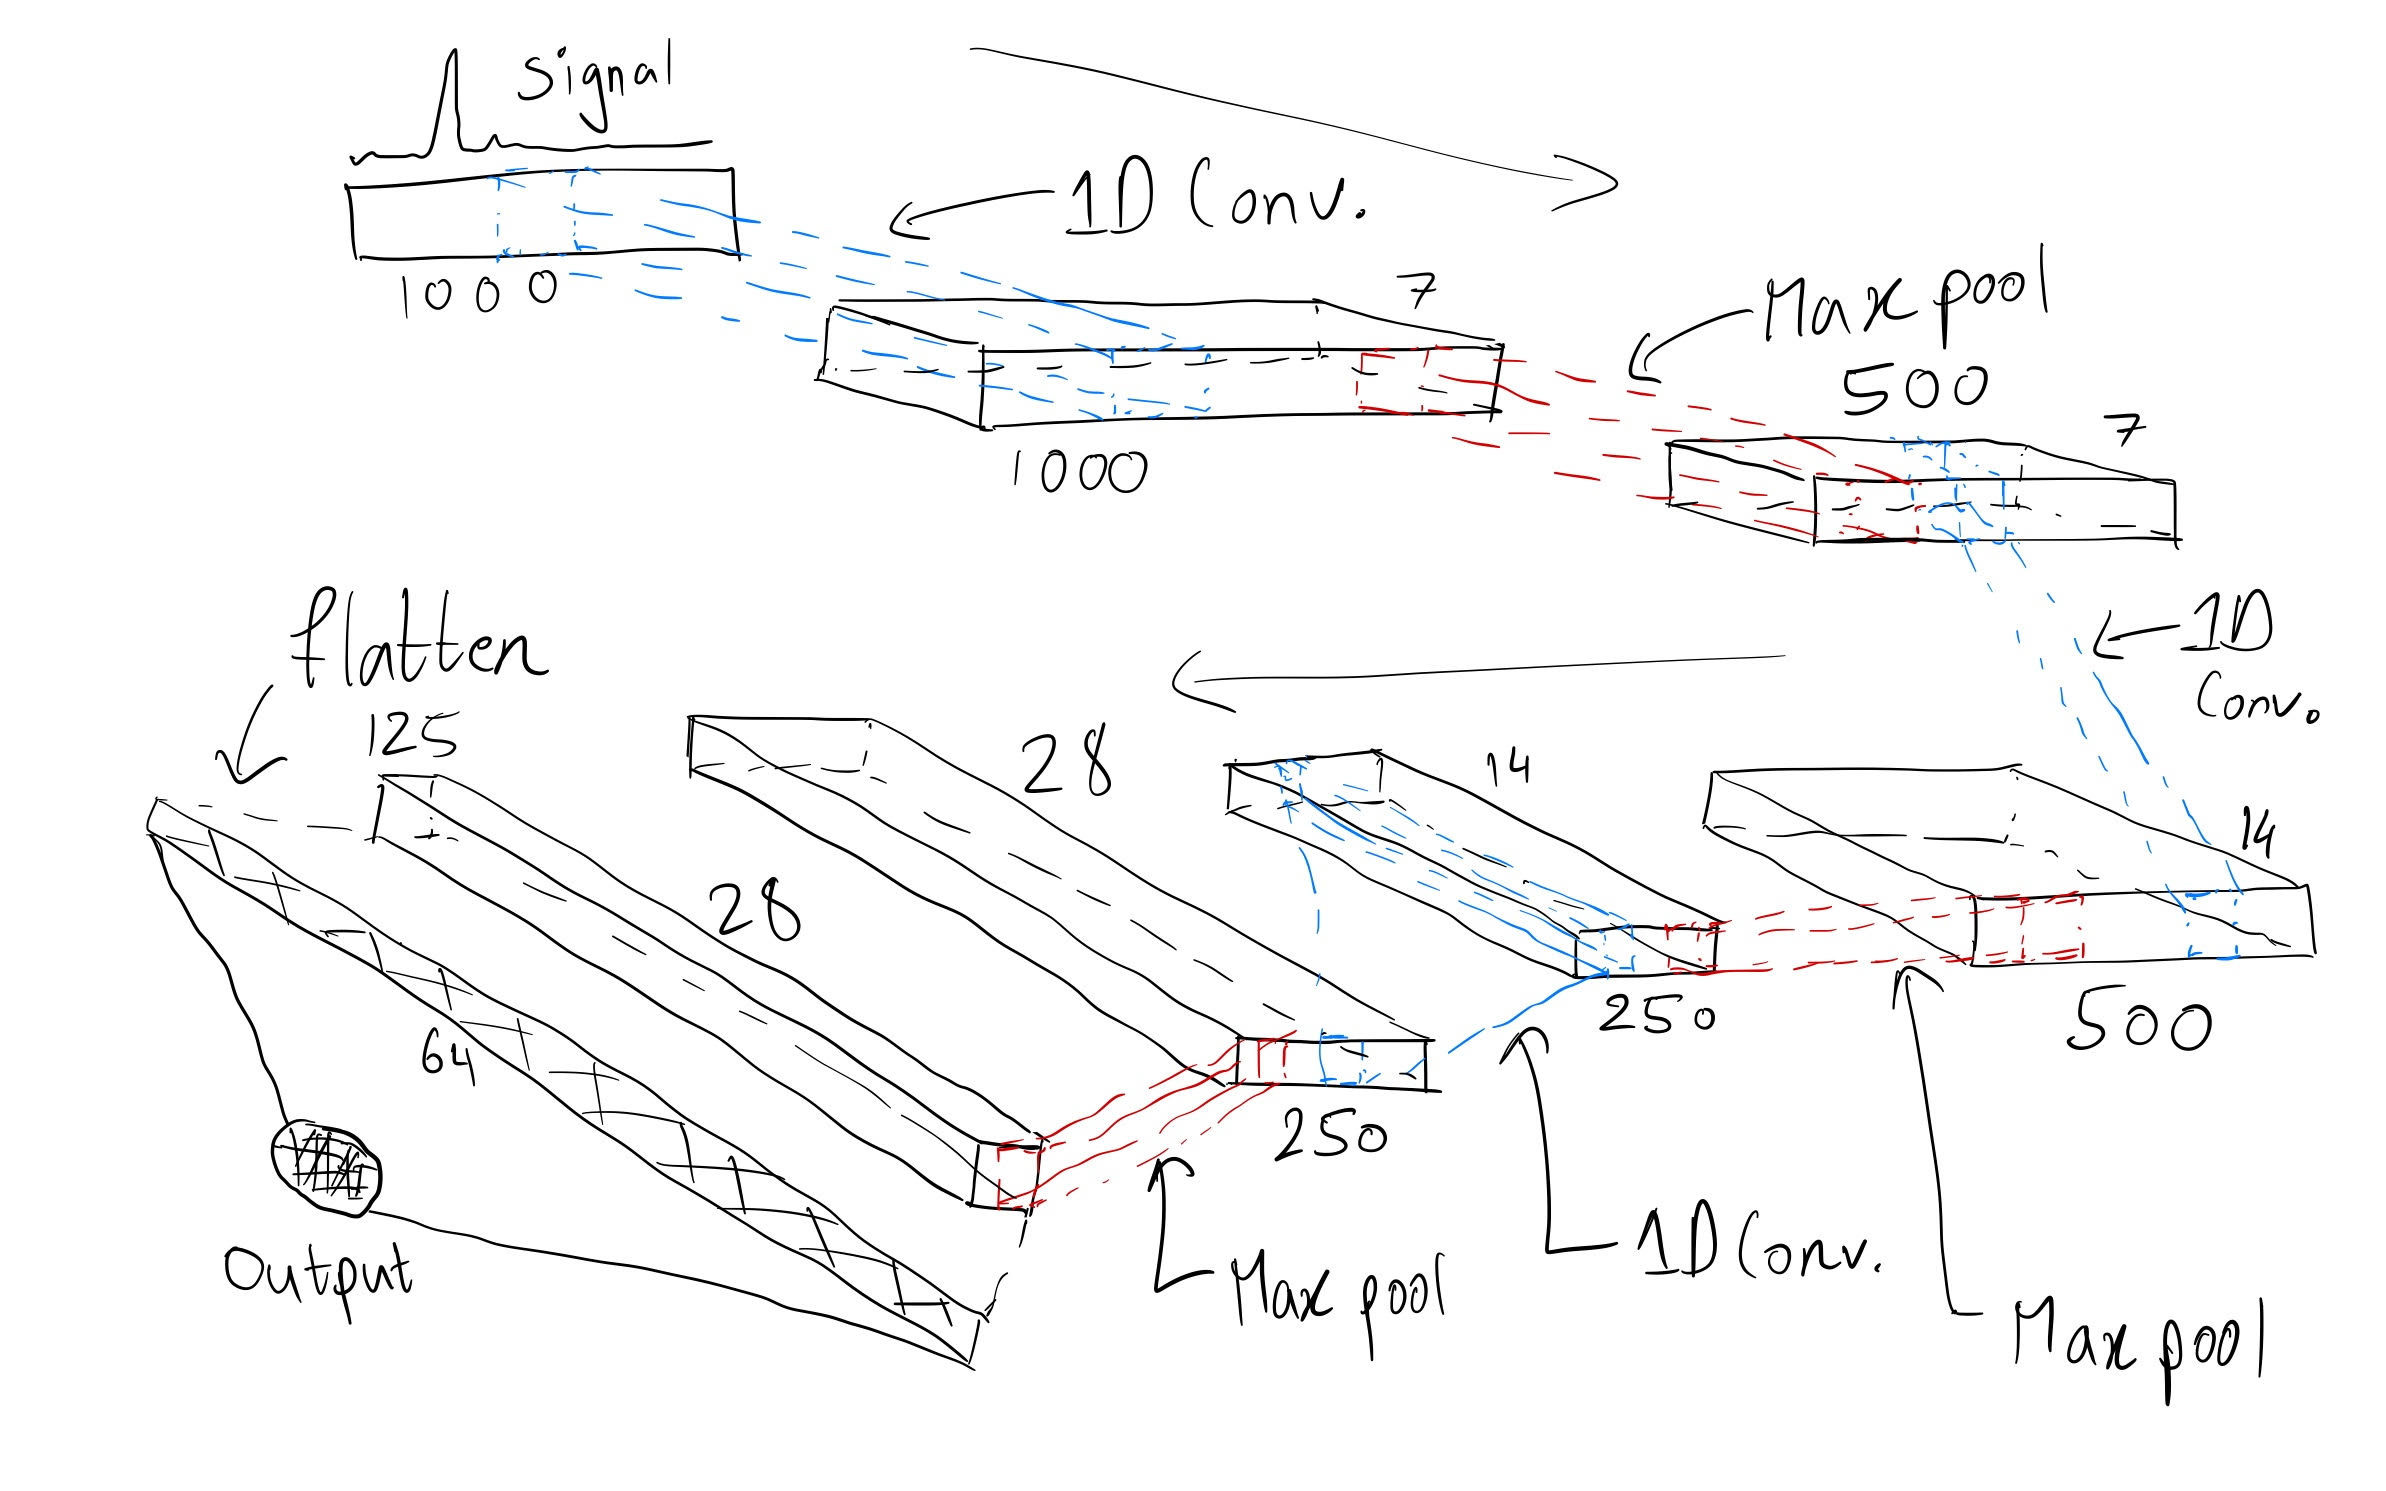

In [56]:
import base64
from IPython.display import HTML

with open("Network_sketch.jpg", "rb") as image_file:
    image_data = image_file.read()

base64_image = base64.b64encode(image_data).decode("utf-8")

html_content = f"""
<img src="data:image/jpeg;base64,{base64_image}" alt="Embedded Image" style="width:800px;">
"""

HTML(html_content)

The schematic above shows how the structure of the data changes as it pass through the network. The layers are labelled, and the output has a single neuron with sigmoid activation, yielding the probability of the signal being a Type 1 (ES) waveform. The arrows are guides for the flow of data through the network.

(If the above image is not visible, please refer to the link below.)

## Section 5: Conclusions

To summarise, we explored the waveform data to visualise the characteristics of each waveform type and simplified the waveform labels for easier analysis. The data was preprocessed according to best practices, leveraging PyTorch's `Dataset` and `DataLoader` primitives to ensure efficient and reproducible data handling.

We developed a flexible, robust, and modular framework for constructing 1D CNNs based on user-defined model architectures. This framework was first tested on synthetic data to demonstrate its utility, after which it was applied to the waveform dataset. For this task, we implemented a model architecture identical to the one presented in ref.

The model was trained on the training dataset, with various epoch-based metrics tracked, including loss, accuracy, AUC scores, weights and biases (as well as their gradients), and training time. These metrics were visualised to provide insights into the training process. The model was then evaluated on the test dataset, achieving a mean AUC score of 0.9953 ± 0.0027, consistent with the results reported in ref. Additionally, we visualised the feature maps of the model as 2D heatmaps to understand how the signal transformed as it passed through the convolutional layers, illustrating how the filters identified patterns and abstractions in the data.

We further tested three alternative models: one with one fewer convolutional and pooling layer, another with an additional convolutional and pooling layer, and a third with an extra fully connected layer, using a smaller kernel size and padding compared to the reference model. Notably, model 2 outperformed the reference model, and we discussed potential reasons for these results. We found that model 2 yielded a mean AUC score of 0.9968 ± 0.0021.

There remains significant scope for further exploration and improvement in this analysis. Our framework was intentionally designed to facilitate such investigations. Future work could involve testing models with different configurations to achieve better performance or reduced training time. Although we replicated many aspects of the discussion in ref., we were unable to reproduce the exact types of feature maps presented there; this point could be explored further. With some minor adjustments, the framework presented here could be made even more flexible by incorporating multiclass functionalities. One could also explore an 'inverted' setup by using the opposite labelling during pre-processing to see if this affects results.

In conclusion, this notebook demonstrates the analysis and results achieved using our framework. A GitHub [repo](https://github.com/farhansharif75/WaveformDiscrimination_1DCNN) has been created to host the notebook, data, and trained models used in this work.

**For transparency, we disclose the use of ChatGPT in certain aspects of this work. Some explanations were refined and clarified with the help of this tool. Additionally, elements of the code, such as the modularity and flexibility of the main neural network class, feature map visualisations, tracking of model parameters during training, and the model schematic, were influenced to some extent by ChatGPT. However, the majority of the work presented remains the author’s own.**

### Reference

Griffiths, J., Kleinegesse, S., Saunders, D., Taylor, R., & Vacheret, A. (2020). *Pulse shape discrimination and exploration of scintillation signals using convolutional neural networks. Machine Learning: Science and Technology*, 1(4), 045006. https://doi.org/10.1088/2632-2153/abb781